# Project Objectives

The objective of this project is to develop and evaluate machine learning models that predict patient outcomes using clinical data collected during Intensive Care Unit (ICU) stays.

This project focuses on outcome prediction within the ICU, where patients are already critically ill, and identifying high-risk patients can inform clinical decision-making.

The specific goals of this project are to:
- Evaluate missing data in the ICU dataset and apply appropriate imputation strategies.
- Assess whether raw clinical measurements provide predictive signal for patient outcomes.
- Engineer temporal features to capture patient health trajoectories during ICU stay.
- Compare baseline models trained on raw features with enhanced models incorporating both raw and engineered temporal features.
- Evaluate model performance under severe class imbalance using metrics suitable for rare events.

Given the clinical context, false negatives may represent missed high-risk patients, while false positives may lead to unnecessary interventions. Therefore, this project emphasizes recall-focused evaluation and precision–recall metrics (PR-AUC) rather than overall accuracy.

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import utility as util
import shap

RANDOM_STATE = 42

# Data Loading

**Data Souce**:
The dataset used in this project is publicly availabe on Kaggle - Death Classification in ICU:
https://www.kaggle.com/datasets/fdemoribajolin/death-classification-icu

In [2]:
X_train=pd.read_csv('./data/X_train_2025.csv')
Y_train=pd.read_csv('./data/y_train_2025.csv')

In [3]:
print(X_train.shape)
print(Y_train.shape)

(3600, 120)
(3600, 1)


In [4]:
df=pd.concat([X_train,Y_train],axis=1)
df.head()

recordid  SAPS-I  SOFA   Age  Gender  Height  Weight  CCU  CSRU  SICU  ...  \
0    137517      -1     2  56.0     0.0     NaN    79.6    0     0     0  ...   
1    145680      10     3  72.0     1.0     NaN    70.0    0     0     0  ...   
2    138649      -1     8  81.0     0.0     NaN     NaN    0     0     0  ...   
3    149075      16     8  56.0     1.0   180.3    94.8    1     0     0  ...   
4    141408      14     7  52.0     1.0   182.9   120.6    0     1     0  ...   

   TroponinI_last  TroponinT_last  WBC_last  Weight_last  pH_last  \
0             NaN             NaN       7.3         79.6      NaN   
1             NaN            0.07       2.4         70.0     7.48   
2             NaN             NaN       7.0          NaN      NaN   
3             NaN             NaN      11.4         98.9     7.44   
4             NaN             NaN       9.0        120.6     7.43   

   MechVentStartTime  MechVentDuration  MechVentLast8Hour  UrineOutputSum  \
0                NaN               NaN                NaN             NaN   
1                NaN               NaN                NaN             NaN   
2                NaN               NaN                NaN             NaN   
3             1128.0             470.0                0.0             4.0   
4              143.0            2580.0                1.0            16.0   

   In-hospital_death  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 121 columns]

In [5]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 3600
Number of columns: 121


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Columns: 121 entries, recordid to In-hospital_death
dtypes: float64(114), int64(7)
memory usage: 3.3 MB


### Dataset Overview

The dataset contains **3,600 patient records** with **121 variables**:

- **recordid:** Unique identifier for each patient  
- **Target:** `In-hospital_death`, binary variable indicates patient survived (`0`) or died (`1`)
- **Clinical features:** 119 columns with historical patient measurements, including vitals and laboratory results


# Exploratory Data Analysis (EDA)

In [7]:
# Statistical summary
df.describe()

recordid       SAPS-I         SOFA          Age       Gender  \
count    3600.000000  3600.000000  3600.000000  3600.000000  3596.000000   
mean   140964.911389    14.187500     6.311111    64.462778     0.563126   
std      5583.521700     6.061105     4.191431    17.630796     0.496068   
min    132539.000000    -1.000000    -1.000000    15.000000     0.000000   
25%    136374.500000    11.000000     3.000000    53.000000     0.000000   
50%    140071.500000    15.000000     6.000000    67.000000     1.000000   
75%    145233.750000    18.000000     9.000000    78.000000     1.000000   
max    152851.000000    34.000000    22.000000    90.000000     1.000000   

             Height       Weight          CCU         CSRU         SICU  ...  \
count   1862.000000  3277.000000  3600.000000  3600.000000  3600.000000  ...   
mean     175.749198    81.729774     0.140556     0.213611     0.281944  ...   
std      256.371473    23.677343     0.347611     0.409912     0.450009  ...   
min      121.900000    36.500000     0.000000     0.000000     0.000000  ...   
25%      162.600000    66.000000     0.000000     0.000000     0.000000  ...   
50%      170.200000    79.000000     0.000000     0.000000     0.000000  ...   
75%      177.800000    92.000000     0.000000     0.000000     1.000000  ...   
max    11220.000000   280.000000     1.000000     1.000000     1.000000  ...   

       TroponinI_last  TroponinT_last     WBC_last  Weight_last      pH_last  \
count      175.000000      786.000000  3516.000000  2407.000000  2748.000000   
mean         6.714857        0.923537    12.361761    85.064769     7.399782   
std          9.643306        2.163239     6.309717    24.617355     0.060998   
min          0.300000        0.010000     1.000000    36.200000     7.030000   
25%          0.800000        0.040000     8.500000    68.300000     7.370000   
50%          1.700000        0.120000    11.300000    82.000000     7.410000   
75%          8.800000        0.567500    14.800000    97.400000     7.440000   
max         46.000000       19.700000   130.900000   280.000000     7.630000   

       MechVentStartTime  MechVentDuration  MechVentLast8Hour  UrineOutputSum  \
count        2264.000000        2264.00000        2264.000000     2264.000000   
mean          292.278269        1895.00530           0.617049       12.120141   
std           494.095873         876.76375           0.486214        5.818560   
min             0.000000           0.00000           0.000000        1.000000   
25%            52.000000        1140.00000           0.000000        7.000000   
50%           118.000000        2281.50000           1.000000       13.000000   
75%           241.000000        2670.00000           1.000000       16.000000   
max          2854.000000        2880.00000           1.000000       38.000000   

       In-hospital_death  
count        3600.000000  
mean            0.139722  
std             0.346747  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 121 columns]

In [8]:
#Check if there are any duplicate rows
duplicate_check=df.duplicated().sum()
print('Number of duplicate rows:', duplicate_check)

Number of duplicate rows: 0


## Target Distribution

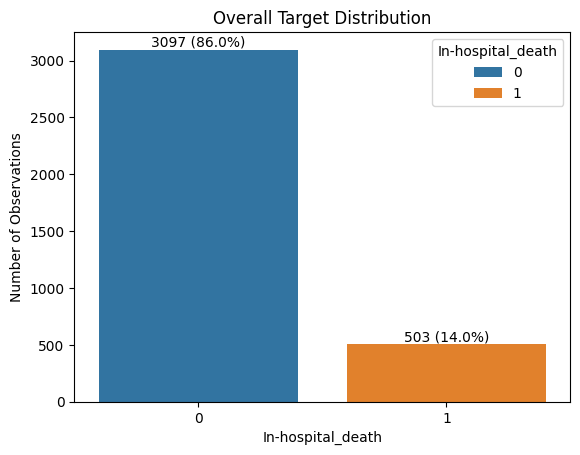

In [9]:
util.plot_target_distribution(df,'In-hospital_death', 'Overall Target Distribution')

## Feature Distribution

In [10]:
numeric_cols=df.select_dtypes(include=['int64','float64']).columns.tolist()
# Exclude columns that contains the unique identifer, target label, binary flagging indicators, timestamp
columns_to_exclude=['recordid','In-hospital_death','CCU','CSRU','SICU','Gender','MechVentLast8Hour','MechVentStartTime']
for column in columns_to_exclude:
  numeric_cols.remove(column)
numeric_cols.sort()

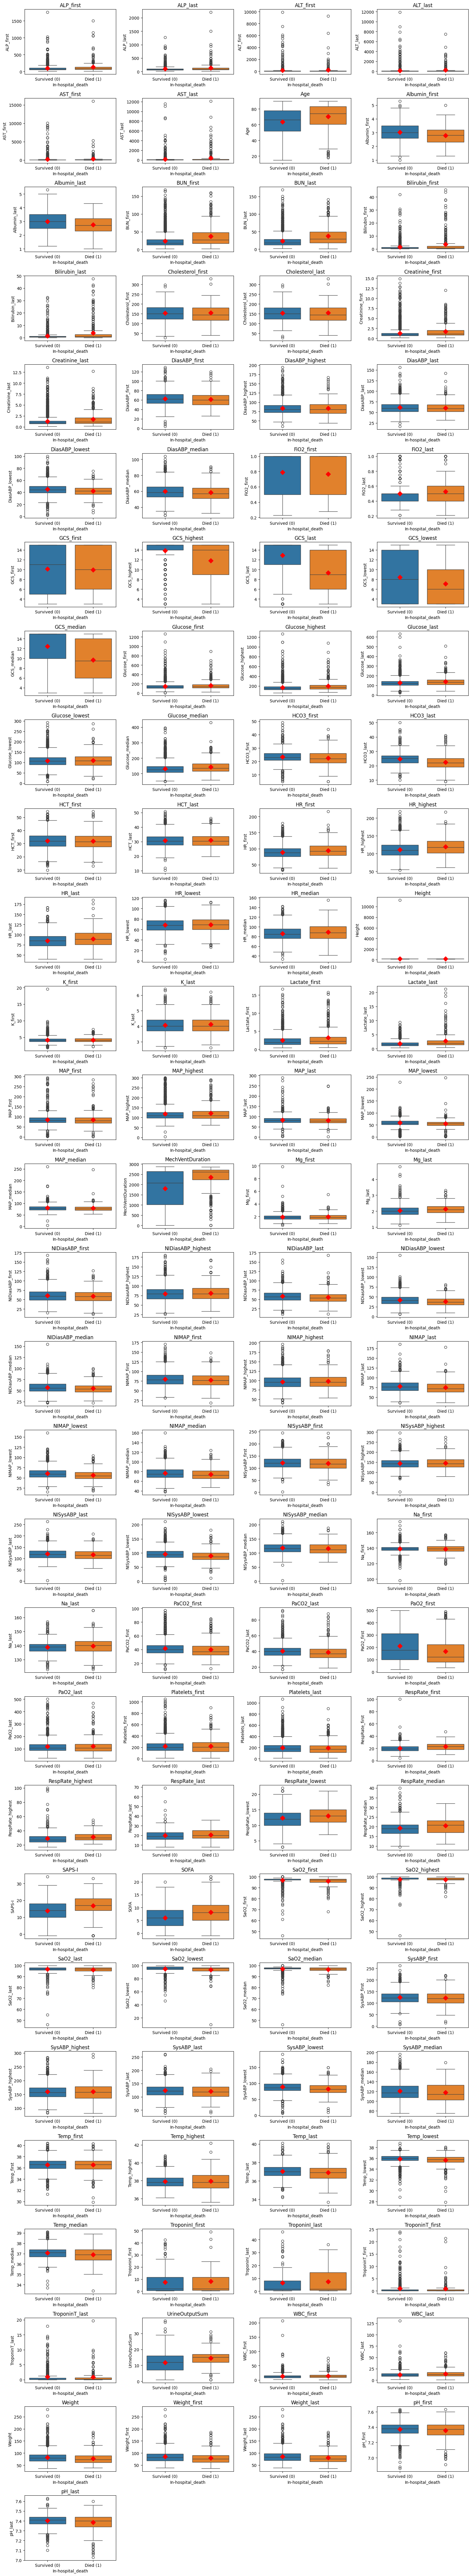

In [11]:
#Raw numeric features distribution
util.plot_boxplots(df, numeric_cols, 'In-hospital_death')

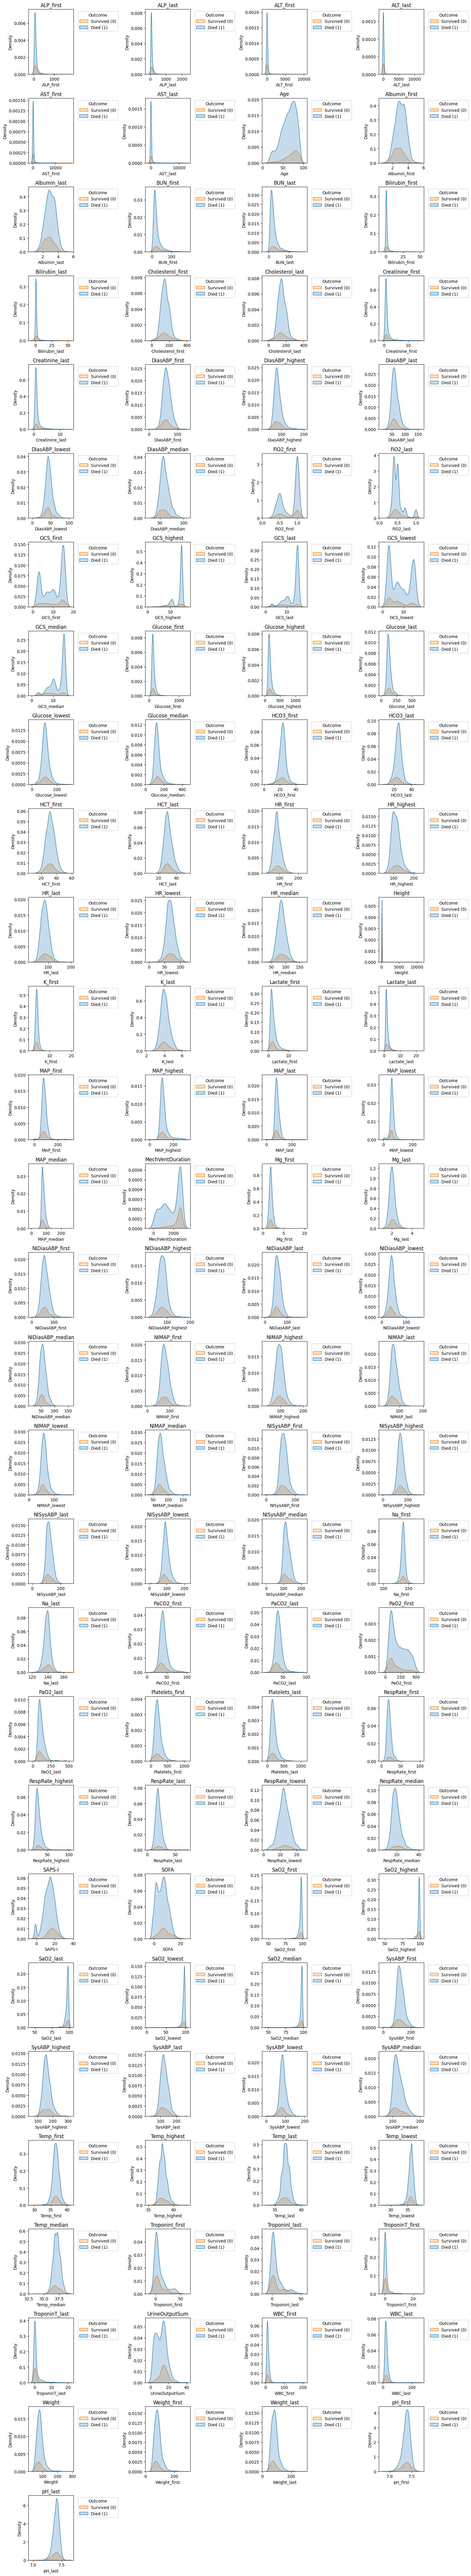

In [12]:
# Plot KDE plots for raw numeric features
util.plot_kde_plots(df, numeric_cols, 'In-hospital_death')

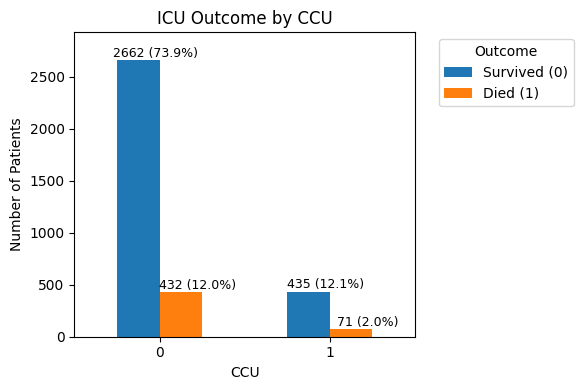

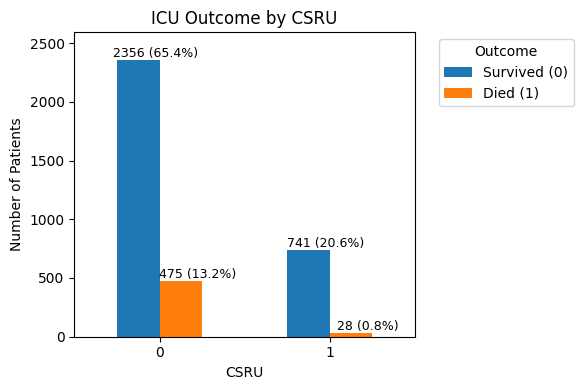

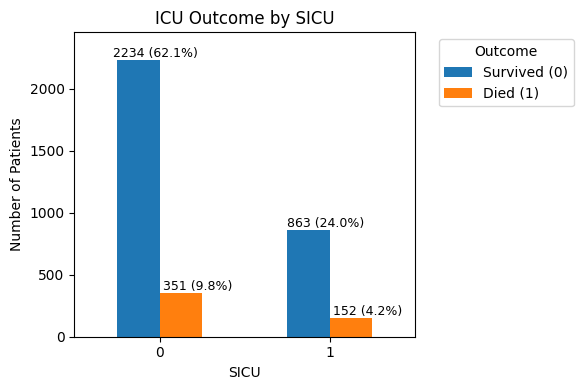

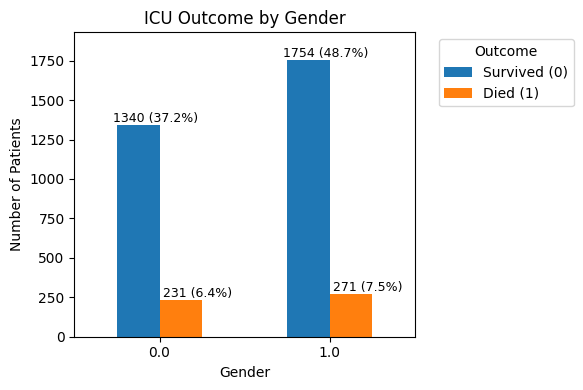

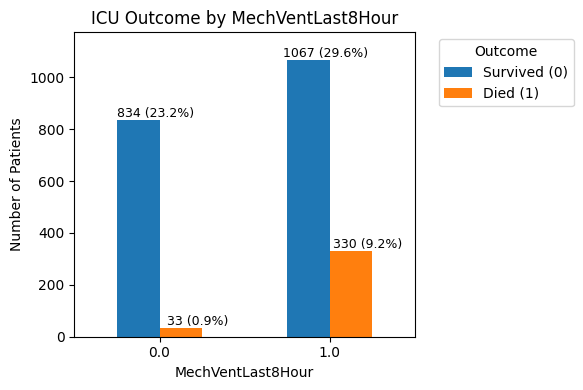

In [13]:
# Binary feature bar plots
binary_features = ['CCU', 'CSRU', 'SICU', 'Gender', 'MechVentLast8Hour']
util.plot_binary_feature_bars(df, binary_features, 'In-hospital_death')

## Correlation Analysis

**Features to Features** correlation

In [14]:
corr_matrix = df.corr().abs()

# Find pairs with correlation > threshold
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:  # Threshold for multicollinearity
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
print(high_corr_df)

            feature1          feature2  correlation
7  Cholesterol_first  Cholesterol_last     0.999506
8       Weight_first       Weight_last     0.970491
0             Weight      Weight_first     0.966296
6    Bilirubin_first    Bilirubin_last     0.953783
1             Weight       Weight_last     0.936813
4          ALT_first         AST_first     0.916680
3  NIDiasABP_highest     NIMAP_highest     0.910603
5      Albumin_first      Albumin_last     0.908733
2    NIDiasABP_first       NIMAP_first     0.906723


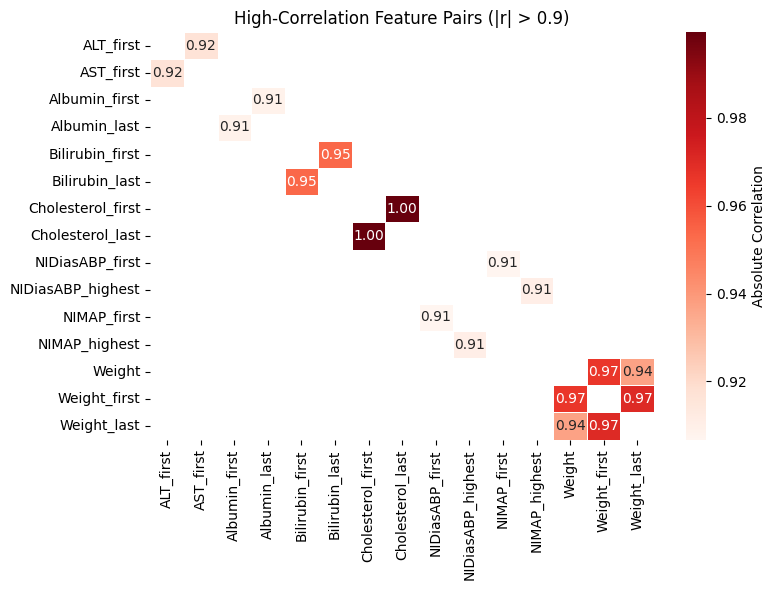

In [15]:
pair_heatmap = high_corr_df.pivot(
    index='feature1',
    columns='feature2',
    values='correlation'
)

# Make the heatmap symmetric
pair_heatmap = pair_heatmap.combine_first(pair_heatmap.T)

plt.figure(figsize=(8, 6))

sns.heatmap(
    pair_heatmap,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={'label': 'Absolute Correlation'}
)

plt.title('High-Correlation Feature Pairs (|r| > 0.9)')
plt.tight_layout()
plt.show()

**Feature to Outcome** correlation

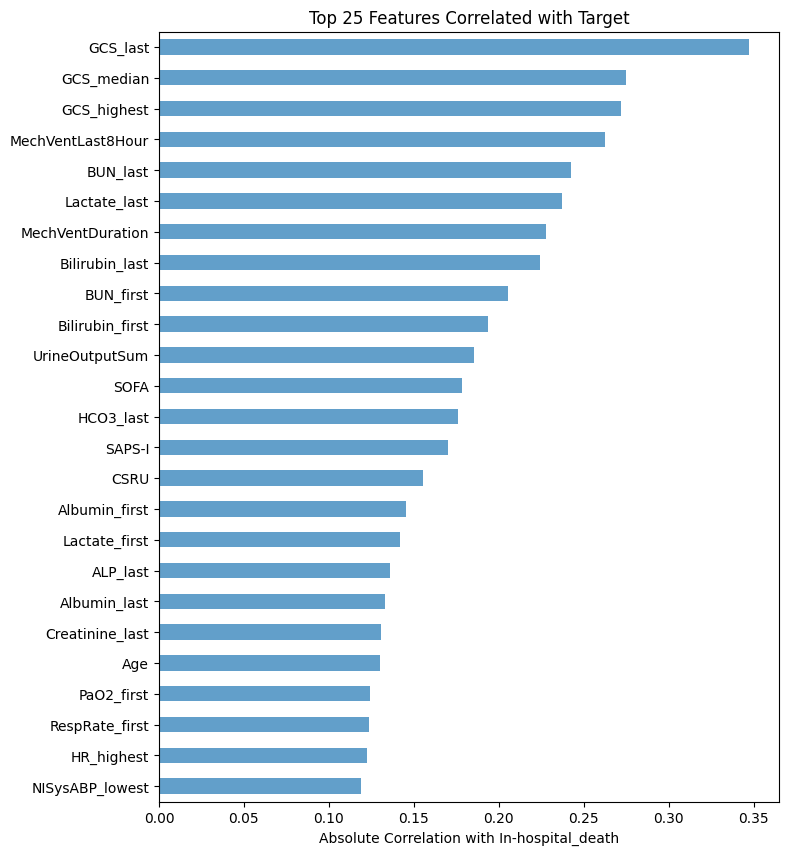

In [16]:
target_corr = df.corr()['In-hospital_death'].abs().sort_values(ascending=False).drop('In-hospital_death')

# Visualize top correlations
target_corr.head(25).plot(kind='barh', figsize=(8, 10),alpha=0.7)
plt.title('Top 25 Features Correlated with Target')
plt.xlabel('Absolute Correlation with In-hospital_death')
plt.gca().invert_yaxis()
plt.savefig(r'.\results\Top_25_features_correlated_to_target.png', dpi=150, bbox_inches='tight')
plt.show()

## Missing Data

### Patient Level (Row)

In [17]:
# Calculate patient-level data completeness
patient_level_completeness = df.notnull().mean(axis=1)

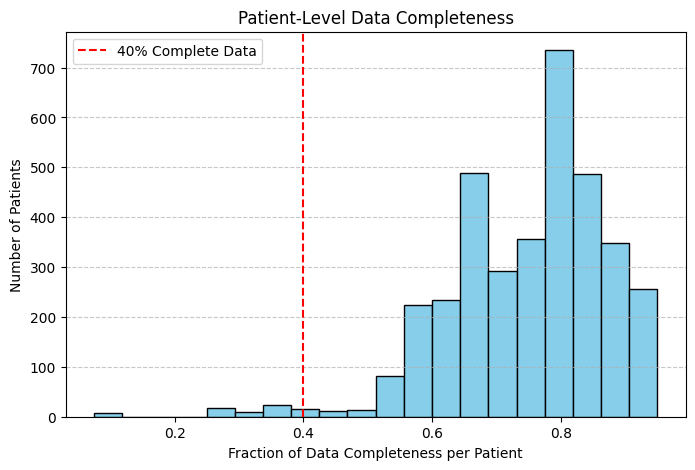

In [18]:
# Plot histogram of patient-level data completeness
plt.figure(figsize=(8,5))
plt.hist(patient_level_completeness, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.4, color='red', linestyle='--', label='40% Complete Data')
plt.xlabel('Fraction of Data Completeness per Patient')
plt.ylabel('Number of Patients')
plt.title('Patient-Level Data Completeness')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

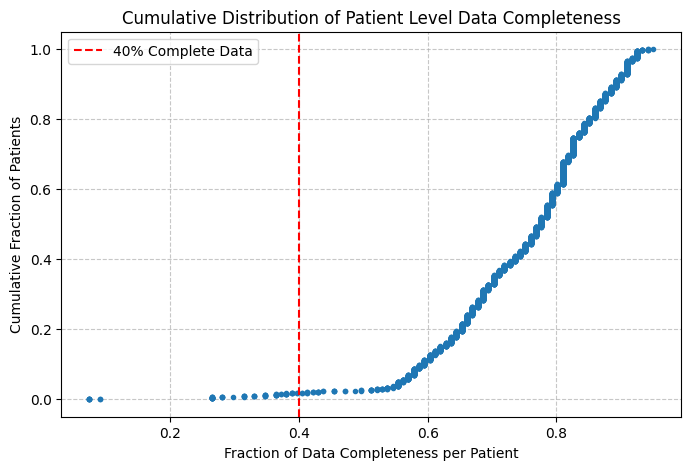

In [19]:
# Plot cumulative distribution of patient-level data completeness
sorted_complete = np.sort(patient_level_completeness)
cdf = np.arange(1, len(patient_level_completeness)+1) / len(patient_level_completeness)

plt.figure(figsize=(8,5))
plt.plot(sorted_complete, cdf, marker='.', linestyle='none')
plt.axvline(0.4, color='red', linestyle='--', label='40% Complete Data')
plt.xlabel('Fraction of Data Completeness per Patient')
plt.ylabel('Cumulative Fraction of Patients')
plt.title('Cumulative Distribution of Patient Level Data Completeness')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [20]:
# Analyze impact of different completeness thresholds
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in thresholds:
    kept = (patient_level_completeness >= t).sum()
    dropped = df.shape[0] - kept
    print(f"Patient Level Data Completeness at >={t*100:.0f}%: Keep {(kept/df.shape[0]*100):.3f}% ({kept}/{df.shape[0]}) patients, Drop {dropped} patients")

Patient Level Data Completeness at >=40%: Keep 98.167% (3534/3600) patients, Drop 66 patients
Patient Level Data Completeness at >=50%: Keep 97.444% (3508/3600) patients, Drop 92 patients
Patient Level Data Completeness at >=60%: Keep 88.778% (3196/3600) patients, Drop 404 patients
Patient Level Data Completeness at >=70%: Keep 67.222% (2420/3600) patients, Drop 1180 patients
Patient Level Data Completeness at >=80%: Keep 41.056% (1478/3600) patients, Drop 2122 patients
Patient Level Data Completeness at >=90%: Keep 8.750% (315/3600) patients, Drop 3285 patients


In [21]:
print(df[patient_level_completeness<=0.4]['In-hospital_death'].value_counts())

In-hospital_death
0    64
1     2
Name: count, dtype: int64


### Variable Level (column)

In [22]:
# Feature-level missing data
missing_features_summary_df=pd.DataFrame({
    '# Missing': df.isnull().sum(),
    '% Missing': df.isnull().mean()*100}).sort_values(by='# Missing', ascending=False)
print('Top 20 missing data columns:', missing_features_summary_df.head(20))

Top 20 missing data columns:                    # Missing  % Missing
TroponinI_first         3425  95.138889
TroponinI_last          3425  95.138889
Cholesterol_last        3325  92.361111
Cholesterol_first       3325  92.361111
TroponinT_first         2814  78.166667
TroponinT_last          2814  78.166667
RespRate_highest        2606  72.388889
RespRate_lowest         2606  72.388889
RespRate_first          2606  72.388889
RespRate_last           2606  72.388889
RespRate_median         2606  72.388889
Albumin_first           2128  59.111111
Albumin_last            2128  59.111111
ALP_first               2068  57.444444
ALP_last                2068  57.444444
Bilirubin_last          2041  56.694444
ALT_last                2041  56.694444
Bilirubin_first         2041  56.694444
ALT_first               2041  56.694444
AST_first               2038  56.611111


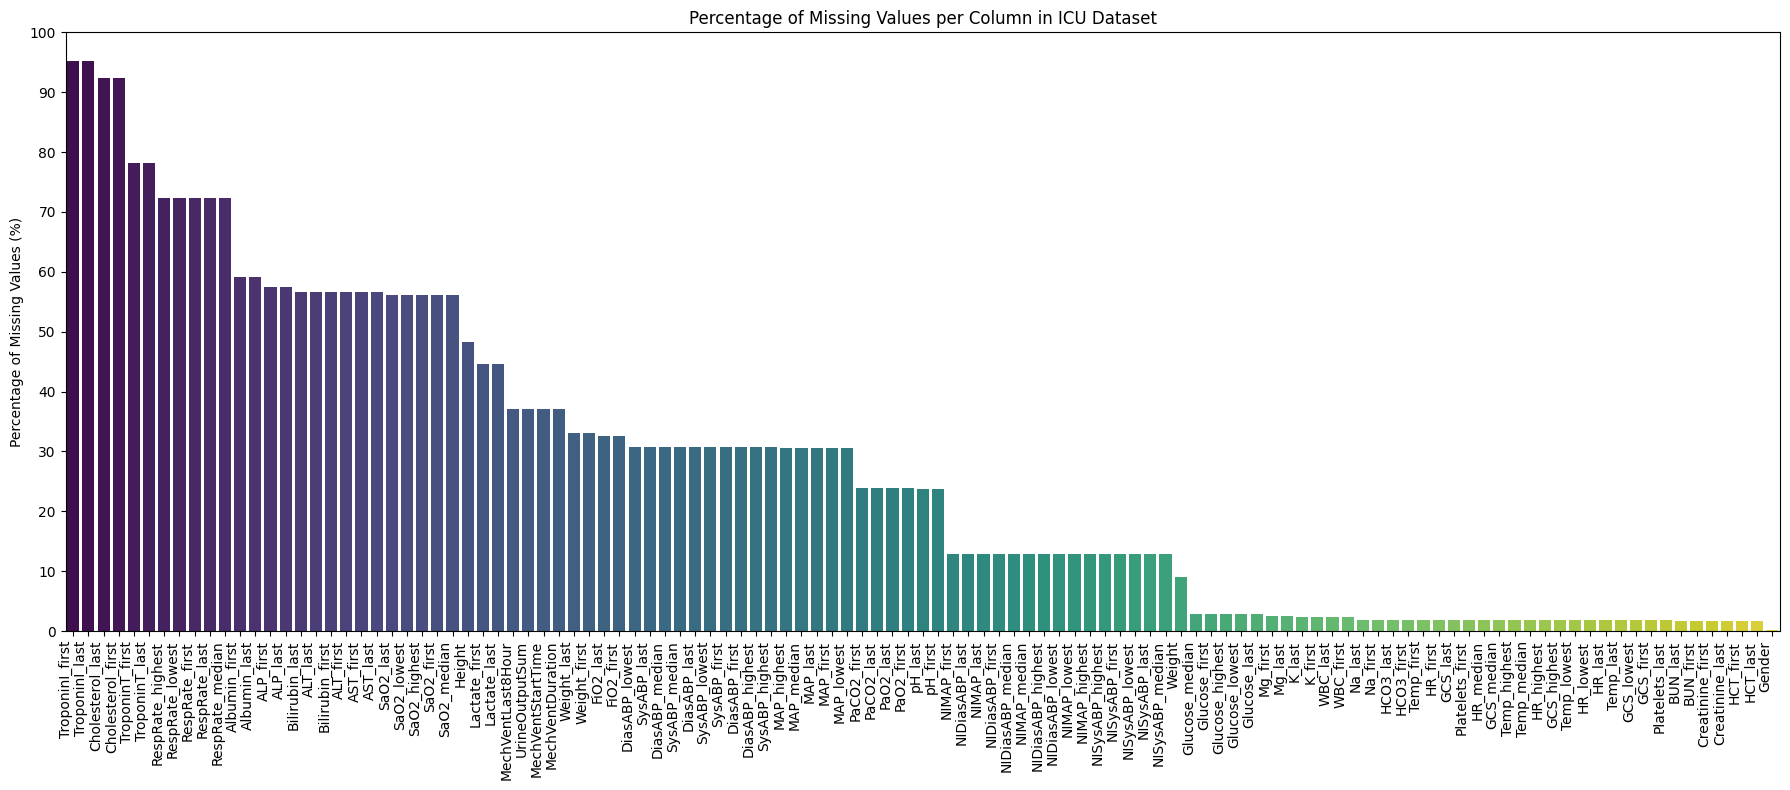

In [23]:
# Visualize Feature-level missing Data Distribution

# Filter columns that have at least one missing value
missing_pct = missing_features_summary_df[missing_features_summary_df['% Missing'] > 0]

# Plot Missing Data Distribution
plt.figure(figsize=(18,8))
sns.barplot(x=missing_pct.index, y=missing_pct['% Missing'], palette='viridis')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Percentage of Missing Values (%)')
plt.xlabel('')
plt.title('Percentage of Missing Values per Column in ICU Dataset')
plt.ylim(0, 100)
plt.yticks(range(0,101,10))
plt.tight_layout()
plt.show()


## Statistical Test

**Mann-Whitney U** and **rank-biserial correlation** are applied to evaluate the non-parametric numeric features to assess the distribution difference between the survival and non-surived ICU outcome.

**Null Hypothesis (H₀):** The distribution of a feature is the same between the survival and non-survival outcomes.  
**Alternative Hypothesis (H₁):** The distribution of a feature differs between the survival and non-survival outcomes.

**Rank-biserial correlation** is used to quanity the mangnitude of the difference in Effect Size:
- Effect Size **< 0.1**: Negligible
- Effect Size **> 0.1 to 0.3**: Small
- Effect Size **> 0.3 to 0.5**: Medium
- Effect size **> 0.5**: Large

In [24]:
# Get the binary features
print(binary_features)

# Get the numeric features
numeric_cols = [col for col in df.select_dtypes(include=['int64','float64']).columns.tolist() if col not in binary_features + ['recordid','In-hospital_death']]

['CCU', 'CSRU', 'SICU', 'Gender', 'MechVentLast8Hour']


In [25]:
#Call the mann_whitney_u_test function
mw_u_df=util.mann_whitney_u_test(df, outcome_col='In-hospital_death', numeric_cols=numeric_cols)

# Sort by p-value and filter significant features
mw_u_df=mw_u_df.sort_values(by='p-value', ascending=True)

# Add effect size interpretation
mw_u_df['Effect Size Interpretation'] = mw_u_df['Effect Size Abs'].apply(util.interpret_effect_size)

In [26]:
# Numeric Features with no significant difference
NoSig_df_raw=mw_u_df[mw_u_df['p-value']>=0.05].sort_values(by='p-value', ascending=False)
NoSig_df_raw

U-statistic   p-value  Median Survived  Median Died  \
Feature                                                                  
MAP_highest           390865.0  0.879738           110.00       110.00   
Temp_first            760678.5  0.832396            36.60        36.60   
HCT_last              756593.5  0.816277            30.30        30.40   
Cholesterol_first       4711.0  0.813564           150.00       145.00   
Cholesterol_last        4711.5  0.812720           150.00       145.00   
Temp_highest          761534.5  0.800800            37.80        37.80   
K_first               759794.0  0.727734             4.10         4.10   
SysABP_highest        394895.0  0.696930           157.00       158.00   
DiasABP_highest       395163.0  0.681373            81.00        81.00   
NISysABP_highest      601455.5  0.661680           142.00       142.50   
TroponinT_first        52937.0  0.659028             0.12         0.13   
TroponinI_last          2826.5  0.541983             1.70         1.80   
TroponinT_last         52394.5  0.518919             0.12         0.13   
NIMAP_highest         597002.5  0.469202            95.33        95.33   
MechVentStartTime     353418.0  0.462460           122.00       103.00   
Glucose_lowest        732460.5  0.435782           106.00       108.00   
TroponinI_first         2775.5  0.434538             1.95         2.10   
PaO2_last             513482.0  0.432946           106.00       105.00   
K_last                735836.5  0.426736             4.00         4.00   
Platelets_first       779960.5  0.346026           200.00       201.00   
ALT_first             184869.5  0.300876            30.00        31.00   
NIDiasABP_highest     590258.0  0.298253            79.00        79.00   
RespRate_last          33879.0  0.275298            19.00        20.00   
Height                195039.5  0.248098           170.20       170.20   
HCT_first             786357.5  0.241426            31.90        31.50   
GCS_first             781535.5  0.213867            11.00        10.00   
Na_first              788357.0  0.146020           139.00       139.00   
MAP_first             411757.5  0.138266            82.00        81.00   
Mg_first              719107.5  0.110432             1.90         1.90   
HR_lowest             721042.5  0.095628            68.00        69.00   
FiO2_first            429392.0  0.094362             1.00         1.00   
RespRate_lowest        32432.5  0.092097            12.00        13.00   
Platelets_last        797221.5  0.078760           175.00       171.00   
NIMAP_first           643295.0  0.061682            78.00        76.67   
SysABP_first          413994.0  0.058751           122.00       120.00   
NIDiasABP_first       643673.0  0.050680            59.00        58.00   

                   Effect Size  Effect Size Abs Effect Size Interpretation  
Feature                                                                     
MAP_highest           0.004927         0.004927                 Negligible  
Temp_first           -0.005905         0.005905                 Negligible  
HCT_last              0.006469         0.006469                 Negligible  
Cholesterol_first    -0.023685         0.023685                 Negligible  
Cholesterol_last     -0.023794         0.023794                 Negligible  
Temp_highest         -0.007037         0.007037                 Negligible  
K_first              -0.009704         0.009704                 Negligible  
SysABP_highest       -0.012714         0.012714                 Negligible  
DiasABP_highest      -0.013401         0.013401                 Negligible  
NISysABP_highest      0.012823         0.012823                 Negligible  
TroponinT_first       0.021714         0.021714                 Negligible  
TroponinI_last        0.060339         0.060339                 Negligible  
TroponinT_last        0.031740         0.031740                 Negligible  
NIMAP_highest         0.021191         0.021191    

In [27]:
# Numeric Features with significant difference
Sig_df_raw=mw_u_df[mw_u_df['p-value']<0.05].sort_values(by='p-value', ascending=True)
Sig_df_raw

U-statistic       p-value  Median Survived  Median Died  \
Feature                                                                   
GCS_last          1133143.0  2.612923e-84            15.00         9.00   
GCS_median        1065734.0  5.278606e-54            15.00         9.50   
GCS_highest       1016764.5  1.059903e-51            15.00        14.00   
BUN_last           483845.5  3.977853e-39            18.00        29.00   
BUN_first          510547.0  2.861349e-32            18.00        27.00   
...                     ...           ...              ...          ...   
pH_first           537408.5  2.788112e-02             7.38         7.37   
ALT_last           176819.5  2.973842e-02            29.00        32.00   
MAP_last           420541.0  3.006400e-02            81.00        79.00   
DiasABP_last       416200.0  3.902837e-02            60.00        59.00   
NISysABP_first     644959.0  4.558299e-02           120.00       117.00   

                Effect Size  Effect Size Abs Effect Size Interpretation  
Feature                                                                  
GCS_last          -0.498444         0.498444                     Medium  
GCS_median        -0.409304         0.409304                     Medium  
GCS_highest       -0.344548         0.344548                     Medium  
BUN_last           0.364214         0.364214                     Medium  
BUN_first          0.329127         0.329127                     Medium  
...                     ...              ...                        ...  
pH_first          -0.066253         0.066253                 Negligible  
ALT_last           0.079937         0.079937                 Negligible  
MAP_last          -0.070622         0.070622                 Negligible  
DiasABP_last      -0.067351         0.067351                 Negligible  
NISysABP_first    -0.058580         0.058580                 Negligible  

[78 rows x 7 columns]

**Fisher's Exact Test** and **Odds Ratio** are applied on the binary features to evaluate the associate between the feature to the outcome.

- **Null Hypothesis (H₀)**: The binary feature is independent of the ICU outcome.
- **Alternative Hypthesis (H₁)**: The binary feature is associated with the ICU outcome.

**Odds ratio (OR)** is used to quanity magnitude and the directional association to the outcome:
- OR between **0.8 and 1.2**: Negligible association with the outcome  
- OR **> 1.2**: Increased odds of the adverse outcome  
- OR **< 0.8**: Decreased odds of the adverse outcome

In [28]:
#Call the fisher_exact_test function
fisher_df=util.fisher_exact_test(df, 'In-hospital_death', binary_features)
fisher_df=fisher_df.sort_values(by='p-value', ascending=True)

fisher_df['Odds Ratio Interpretation'] = fisher_df['Odds Ratio'].apply(util.interpret_odds_ratio)
fisher_df

Odds Ratio       p-value Odds Ratio Interpretation
Feature                                                              
MechVentLast8Hour    7.816307  7.773438e-42      Positive Association
CSRU                 0.187422  1.649063e-25      Negative Association
Gender               0.896257  2.647499e-01            No Association
SICU                 1.121008  2.854081e-01            No Association
CCU                  1.005758  9.449556e-01            No Association

## EDA Summary

**Key Findings**:
1. **Target Imbalance**  
   - The outcome variable is highly imbalanced: 86% of patients survived (`0`), 14% died (`1`). This suggests using Precision-Recall–focused metrics rather than accuracy for model evaluation.
2. **Feature Distributions**  
   - Most numeric features are non-normally distributed, and many signals overlap across outcome groups. Individual features alone may have limited discriminative power.
3. **Outliers**  
   - Extreme outliers exist in several features (e.g., height > 1000 units), likely due to clinical anomalies or data entry errors. Outliers will need removal or imputation.
4. **Highly Correlated Features**  
   - Eight features have strong correlations (|r| > 0.9), often representing temporal duplicates (e.g., `Weight`, `Weight_first`, `Weight_last`).  
   - Temporal delta features can replace redundant variables to capture patient-specific trends.
5. **Potentially Predictive Features**  
   - Features such as `GCS`, and `BUN` show apparent association with outcome. Temporal feature engineering may enhance their predictive power.
6. **Missing Data**  
   - Missingness exists at both the patient and feature levels.  
   - Some patients have <20% of features available; certain features (e.g., `TroponinI`, `Cholesterol`) have >90% missing.  
   - While missingness may reflect clinical practice, excessive missing values can reduce model reliability.
7. **Numeric Features Statistical Testing**  
   - Out of 114 numeric features, 78 show p < 0.05 with negligible to medium effect sizes.  
   - Remaining 36 features have p >=0.05 and have negligible to small effect individually but may contribute when combined or engineered for temporal features.
8. **Binary Features Statistical Testing**  
   - 2 out of 5 binary features are significantly associated with outcome.  
   - The remaining 3 (Gender, SICU, CCU) show no association and could be dropped to reduce noise.

**Next Step**: Handle missing data and outliers, data split before imputation.


# Data Preprocessing

## Data Cleaning


**Patient-Level Exclusion**

In [29]:
#Remove if patient is missing more than 60% of data
remove_patients=patient_level_completeness[patient_level_completeness<0.4].index
print('Number of patients removed:', len(remove_patients))

df_clean=df.drop(index=remove_patients)
print('New dataset shape after removing patients with >60% missing data:', df_clean.shape)

Number of patients removed: 66
New dataset shape after removing patients with >60% missing data: (3534, 121)


**Outlier Hanlding**

In [30]:
# Patient with height value >250 are like measurement error
df_clean[df_clean.Height>250][['recordid','Age','Height','Weight','In-hospital_death']]

recordid   Age   Height  Weight  In-hospital_death
167     140620  81.0    308.0    97.3                  0
177     142140  82.0    286.0    94.1                  0
1217    136967  88.0    301.4    99.3                  0
3229    147129  63.0  11220.0    57.9                  0

In [31]:
# Set unrealist height values >250 to NaN
df_clean.loc[df_clean.Height>250, 'Height'] = np.nan

#Summary statistics after cleaning
print(df_clean[['Height']].describe())

            Height
count  1857.000000
mean    169.599735
std      11.023090
min     121.900000
25%     162.600000
50%     170.200000
75%     177.800000
max     208.300000


**Feature Removal**

In [32]:
# Drop MechVentStartTime
#  due to inconsistent data entries
df_clean=df_clean.drop(columns=['MechVentStartTime'],axis=1)

## Data Split

In [33]:
X=df_clean.drop(columns=['recordid','In-hospital_death'],axis=1)
y=df_clean['In-hospital_death']

# Stratisfied train-test split into 30% test and 70% train
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

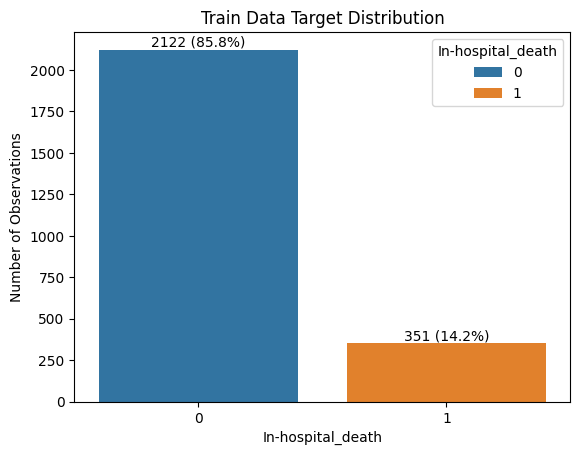

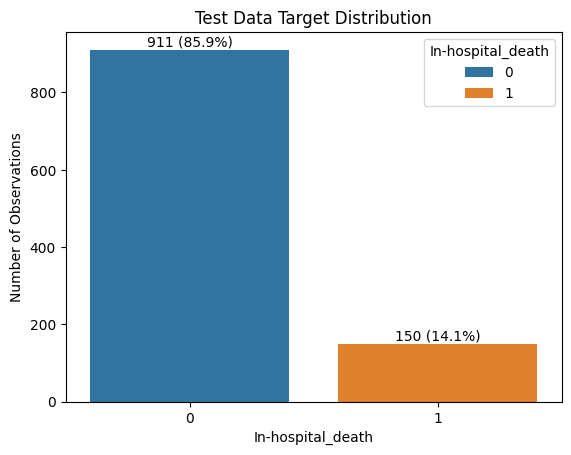

In [34]:
#Visualize target distribution in train and test sets
util.plot_target_distribution(y_train,'In-hospital_death', 'Train Data Target Distribution')
util.plot_target_distribution(y_test,'In-hospital_death', 'Test Data Target Distribution')

## Missing Feature Data Handling & Impuation

Clinical tests in the ICU are ordered based on patient-specific conditions. Missing feature data may reflect clinical decision-making rather than data quality issues and can carry predictive signal for patient outcomes. Based on this understanding, the following imputation straregies are applied:

* Features with **>=20%** missing include a binary indicator flag denoting whether the test was performed (1) or not performed (0).
* Features with **>70%** missing are dropped due to insufficient observations.
* Features with **<=70%** missing are imputed using clinically appropriate values such as the median, mode, or patient-specific historical measurements.

In [35]:
#Remove 'MechVentStartTime' from missing_pct
missing_pct_update=missing_pct[missing_pct.index!='MechVentStartTime']

In [36]:
missing_pct_70=missing_pct_update[missing_pct_update['% Missing']>70] #Features with >70% missing
missing_pct_gt20=missing_pct_update[(missing_pct_update['% Missing']>=20) & (missing_pct_update['% Missing']<=70)] #Features with 20-70% missing
missing_pct_lt20=missing_pct_update[missing_pct_update['% Missing']<20] #Features with <20% missing
missing_pct_any=missing_pct_update[missing_pct_update['% Missing']>0] #Features with missing values   

In [37]:
median_imputer_cols=missing_pct_any.index.tolist() #Columns to impute with median

In [38]:
#Compute median value for imputation from training data
median_values = X_train[median_imputer_cols].median()

**Features missing >70%**

In [39]:
# Features with >70% missing values
missing_pct_70=missing_pct[missing_pct['% Missing']>70]
print(missing_pct_70)

                   # Missing  % Missing
TroponinI_first         3425  95.138889
TroponinI_last          3425  95.138889
Cholesterol_last        3325  92.361111
Cholesterol_first       3325  92.361111
TroponinT_first         2814  78.166667
TroponinT_last          2814  78.166667
RespRate_highest        2606  72.388889
RespRate_lowest         2606  72.388889
RespRate_first          2606  72.388889
RespRate_last           2606  72.388889
RespRate_median         2606  72.388889


In [40]:
#Check if TroponinI or TroponinT was tested
Troponin_cols=['TroponinI_first','TroponinI_last','TroponinT_first','TroponinT_last']
troponin_measured = df[df[Troponin_cols].notnull().any(axis=1)][Troponin_cols]
print(f"Number of records Troponin was tested: {len(troponin_measured)}")

#Check if both TroponinI and TroponinT were tested
troponin_both_measured = X_train[
    df[['TroponinI_first','TroponinI_last']].notnull().any(axis=1) &
    df[['TroponinT_first','TroponinT_last']].notnull().any(axis=1)][Troponin_cols]

print(f"Number of records both TroponinI and TroponinT were tested: {len(troponin_both_measured)}")

Number of records Troponin was tested: 961
Number of records both TroponinI and TroponinT were tested: 0


In [41]:
#Apply Flagging indicator for Troponin and remove original columns
X_train=util.create_measured_flag(X_train, Troponin_cols, 'Troponin_tested', True)
X_test=util.create_measured_flag(X_test, Troponin_cols, 'Troponin_tested', True)

#Check Distribution
print(X_train['Troponin_tested'].value_counts())
print(X_test['Troponin_tested'].value_counts())

Troponin_tested
0    1810
1     663
Name: count, dtype: int64
Troponin_tested
0    773
1    288
Name: count, dtype: int64


In [42]:
#Apply flagging indicator for the Cholestrole and remove original volumns
chol_cols=['Cholesterol_first','Cholesterol_last']
X_train=util.create_measured_flag(X_train, chol_cols, 'Cholesterol_tested', True)
X_test=util.create_measured_flag(X_test, chol_cols, 'Cholesterol_tested', True)

print(X_train['Cholesterol_tested'].value_counts())
print(X_test['Cholesterol_tested'].value_counts())

Cholesterol_tested
0    2296
1     177
Name: count, dtype: int64
Cholesterol_tested
0    965
1     96
Name: count, dtype: int64


In [43]:
#Apply flagging indicator for the Respiration Rate
resp_rate_cols=['RespRate_last','RespRate_highest','RespRate_lowest','RespRate_first','RespRate_median']
X_train=util.create_measured_flag(X_train, resp_rate_cols, 'RespRate_tested', True)
X_test=util.create_measured_flag(X_test, resp_rate_cols, 'RespRate_tested', True)

print(X_train['RespRate_tested'].value_counts())
print(X_test['RespRate_tested'].value_counts())

RespRate_tested
0    1792
1     681
Name: count, dtype: int64
RespRate_tested
0    758
1    303
Name: count, dtype: int64


**Features missing 20% to 70%**

In [44]:
# Features with >20% and <70% missing values
print(missing_pct_gt20.index.sort_values())

Index(['ALP_first', 'ALP_last', 'ALT_first', 'ALT_last', 'AST_first',
       'AST_last', 'Albumin_first', 'Albumin_last', 'Bilirubin_first',
       'Bilirubin_last', 'DiasABP_first', 'DiasABP_highest', 'DiasABP_last',
       'DiasABP_lowest', 'DiasABP_median', 'FiO2_first', 'FiO2_last', 'Height',
       'Lactate_first', 'Lactate_last', 'MAP_first', 'MAP_highest', 'MAP_last',
       'MAP_lowest', 'MAP_median', 'MechVentDuration', 'MechVentLast8Hour',
       'PaCO2_first', 'PaCO2_last', 'PaO2_first', 'PaO2_last', 'SaO2_first',
       'SaO2_highest', 'SaO2_last', 'SaO2_lowest', 'SaO2_median',
       'SysABP_first', 'SysABP_highest', 'SysABP_last', 'SysABP_lowest',
       'SysABP_median', 'UrineOutputSum', 'Weight_first', 'Weight_last',
       'pH_first', 'pH_last'],
      dtype='object')


In [45]:
# Add binary flagging indicator for features with 20-70% missing values
ALP_cols=['ALP_first','ALP_last']
X_train=util.create_measured_flag(X_train, ALP_cols, 'ALP_tested', False)
X_test=util.create_measured_flag(X_test, ALP_cols, 'ALP_tested', False) 

ALT_cols=['ALT_first','ALT_last']
X_train=util.create_measured_flag(X_train, ALT_cols, 'ALT_tested', False)
X_test=util.create_measured_flag(X_test, ALT_cols, 'ALT_tested', False)

AST_cols=['AST_first','AST_last']
X_train=util.create_measured_flag(X_train, AST_cols, 'AST_tested',False)
X_test=util.create_measured_flag(X_test, AST_cols, 'AST_tested',False)

Albumin_cols=['Albumin_first','Albumin_last']
X_train=util.create_measured_flag(X_train, Albumin_cols, 'Albumin_tested',False)
X_test=util.create_measured_flag(X_test, Albumin_cols, 'Albumin_tested',False)  

Bilirubin_cols=['Bilirubin_first','Bilirubin_last']
X_train=util.create_measured_flag(X_train, Bilirubin_cols, 'Bilirubin_tested',False)
X_test=util.create_measured_flag(X_test, Bilirubin_cols, 'Bilirubin_tested',False)

DiasABP_cols=['DiasABP_first','DiasABP_last','DiasABP_highest','DiasABP_lowest','DiasABP_median']
X_train=util.create_measured_flag(X_train, DiasABP_cols, 'DiasABP_tested',False)
X_test=util.create_measured_flag(X_test, DiasABP_cols, 'DiasABP_tested',False)

FiO2_cols=['FiO2_first','FiO2_last']
X_train=util.create_measured_flag(X_train, FiO2_cols, 'FiO2_tested',False)
X_test=util.create_measured_flag(X_test, FiO2_cols, 'FiO2_tested',False)

X_train=util.create_measured_flag(X_train, ['Height'], 'Height_tested',False)
X_test=util.create_measured_flag(X_test, ['Height'], 'Height_tested',False)

Lactate_cols=['Lactate_first','Lactate_last']
X_train=util.create_measured_flag(X_train, Lactate_cols, 'Lactate_tested',False)
X_test=util.create_measured_flag(X_test, Lactate_cols, 'Lactate_tested',False)

MAP_cols=['MAP_first','MAP_last','MAP_highest','MAP_lowest','MAP_median']
X_train=util.create_measured_flag(X_train, MAP_cols, 'MAP_tested',False)
X_test=util.create_measured_flag(X_test, MAP_cols, 'MAP_tested',False)

MechVent_cols=['MechVentDuration','MechVentLast8Hour']
X_train=util.create_measured_flag(X_train, MechVent_cols, 'MechVent_tested',False)
X_test=util.create_measured_flag(X_test, MechVent_cols, 'MechVent_tested',False)

SaO2_cols=['SaO2_first','SaO2_last','SaO2_highest','SaO2_lowest','SaO2_median']
X_train=util.create_measured_flag(X_train, SaO2_cols, 'SaO2_tested',False)
X_test=util.create_measured_flag(X_test, SaO2_cols, 'SaO2_tested',False)

SysABP_cols=['SysABP_first','SysABP_last','SysABP_highest','SysABP_lowest','SysABP_median']
X_train=util.create_measured_flag(X_train, SysABP_cols, 'SysABP_tested',False)
X_test=util.create_measured_flag(X_test, SysABP_cols, 'SysABP_tested',False)    

X_train=util.create_measured_flag(X_train, ['UrineOutputSum'], 'UrineOutput_tested',False)
X_test=util.create_measured_flag(X_test, ['UrineOutputSum'], 'UrineOutput_tested',False)

Weight_cols=['Weight_first','Weight_last']
X_train=util.create_measured_flag(X_train, Weight_cols, 'Weight_tested',False)
X_test=util.create_measured_flag(X_test, Weight_cols, 'Weight_tested',False)



In [46]:
# Fill in median values for imputation except for weights
cols_to_impute_gt20 = missing_pct_gt20.index.difference(['Weight_first', 'Weight_last'])
for col in cols_to_impute_gt20:
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)   

**Weight**: fill in missing values with historical patient-specific data if available. Otherwise, apply the median values.

In [47]:
#Check the numbers with missing values in weights
print(df_clean[['Weight_first','Weight_last','Weight']].isnull().sum())

Weight_first    1132
Weight_last     1132
Weight           264
dtype: int64


In [48]:
# Check the records with any missing values in weights
df_clean[df_clean[['Weight_first','Weight_last','Weight']].isnull().any(axis=1)][['recordid','Weight_first','Weight_last','Weight','In-hospital_death']]

recordid  Weight_first  Weight_last  Weight  In-hospital_death
2       138649           NaN          NaN     NaN                  0
5       150941           NaN          NaN    96.5                  0
6       132584           NaN          NaN    72.8                  0
7       136768           NaN          NaN    75.0                  0
9       149549           NaN          NaN   112.0                  0
...        ...           ...          ...     ...                ...
3581    136941           NaN          NaN    81.8                  0
3584    140001           NaN          NaN    60.0                  1
3585    141936           NaN          NaN    70.0                  0
3594    135631           NaN          NaN    75.0                  0
3599    139102           NaN          NaN     NaN                  0

[1157 rows x 5 columns]

In [49]:
# Fill missing values with historical measurements for Weights
def fill_weight(x_data):

    #Fill weight first and last with historical weight
    x_data['Weight_first']=x_data['Weight_first'].fillna(x_data['Weight'])
    x_data['Weight_last']=x_data['Weight_last'].fillna(x_data['Weight'])

    #Fill weight with first weight
    x_data['Weight']=x_data['Weight'].fillna(x_data['Weight_last'])
    
    return x_data
X_train=fill_weight(X_train)
X_test=fill_weight(X_test)  

In [50]:
# Fill in median values for imputation Weights
for col in ['Weight_first', 'Weight_last', 'Weight']:
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)

**Features missing <20%**

In [51]:
print(missing_pct_lt20.index.sort_values())

Index(['BUN_first', 'BUN_last', 'Creatinine_first', 'Creatinine_last',
       'GCS_first', 'GCS_highest', 'GCS_last', 'GCS_lowest', 'GCS_median',
       'Gender', 'Glucose_first', 'Glucose_highest', 'Glucose_last',
       'Glucose_lowest', 'Glucose_median', 'HCO3_first', 'HCO3_last',
       'HCT_first', 'HCT_last', 'HR_first', 'HR_highest', 'HR_last',
       'HR_lowest', 'HR_median', 'K_first', 'K_last', 'Mg_first', 'Mg_last',
       'NIDiasABP_first', 'NIDiasABP_highest', 'NIDiasABP_last',
       'NIDiasABP_lowest', 'NIDiasABP_median', 'NIMAP_first', 'NIMAP_highest',
       'NIMAP_last', 'NIMAP_lowest', 'NIMAP_median', 'NISysABP_first',
       'NISysABP_highest', 'NISysABP_last', 'NISysABP_lowest',
       'NISysABP_median', 'Na_first', 'Na_last', 'Platelets_first',
       'Platelets_last', 'Temp_first', 'Temp_highest', 'Temp_last',
       'Temp_lowest', 'Temp_median', 'WBC_first', 'WBC_last', 'Weight'],
      dtype='object')


In [52]:
# Features to fill in with median values
cols_to_impute_lt20 = missing_pct_lt20.index.difference(['Gender', 'Weight'])
for col in cols_to_impute_lt20:
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)

In [53]:
# Gender to fill in with mode value
Gender_mode=X_train['Gender'].mode()[0]

X_train['Gender'].fillna(Gender_mode, inplace=True)
X_test['Gender'].fillna(Gender_mode, inplace=True)

In [54]:
# Verify no missing values remain
print('Missing values in X_train after imputation:', X_train.isnull().sum().sum())
print('Missing values in X_test after imputation:', X_test.isnull().sum().sum())

Missing values in X_train after imputation: 0
Missing values in X_test after imputation: 0


### Data Preprocessing Summary

1. **Data Cleaning**
   - **Patient-level exclusion**: Patients missing more than 60% of features (66 records) were removed. Extreme sparsity indicates insufficient clinical information, which may introduce noise, bias imputation, and reduce model stability.
   - **Outlier handling**: Implausible values in `Height` (>=250 units) were set to missing and subsequently imputed using the median of the training set to prevent data leakage.
   - **Feature removal**: `MechVentTimeStamp` was excluded due to inconsistent and non-standardized entries that could not be reliably interpreted.

2. **Data Split**
   - **Training set**: 70%  
   - **Test set**: 30%  
   - To prevent data leakage, the train–test split is performed prior to missing value imputation. All imputation parameters (e.g., median or mode values) are derived from the training set and then applied to the test set.

3. **Missing Data Handling & Imputation**
   - **Missingness indicators**: For features with >=20% missing values, binary indicators were created (1 = test performed, 0 = test not performed) to capture potential clinical decision-making signals.
   - **High-missingness features**: Features with >70% missing values were removed due to insufficient coverage for reliable learning or interpretation.
   - **Imputation strategy**: Features with <=70% missing values were imputed using:
     - Median values for continuous variables
     - Mode for categorical variables (e.g., Gender)
     - Patient-specific historical measurements (e.g., weight) when available

**Next steps**: Baseline modeling, feature engineering, and feature reduction.


# Baseline Model (Linear Regression L1-regularized)

In [55]:
# Features scaling
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


# Add the feature names back to scaled data
X_train_scaled_df=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df=pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [56]:
#---------------
# Baseline Model Training
#---------------
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, class_weight='balanced',max_iter=1000)
logreg_l1.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [57]:
print('Number of iterations:', logreg_l1.n_iter_[0])

Number of iterations: 20


In [58]:
# Predictions
y_prob_test=logreg_l1.predict_proba(X_test_scaled)[:,1]

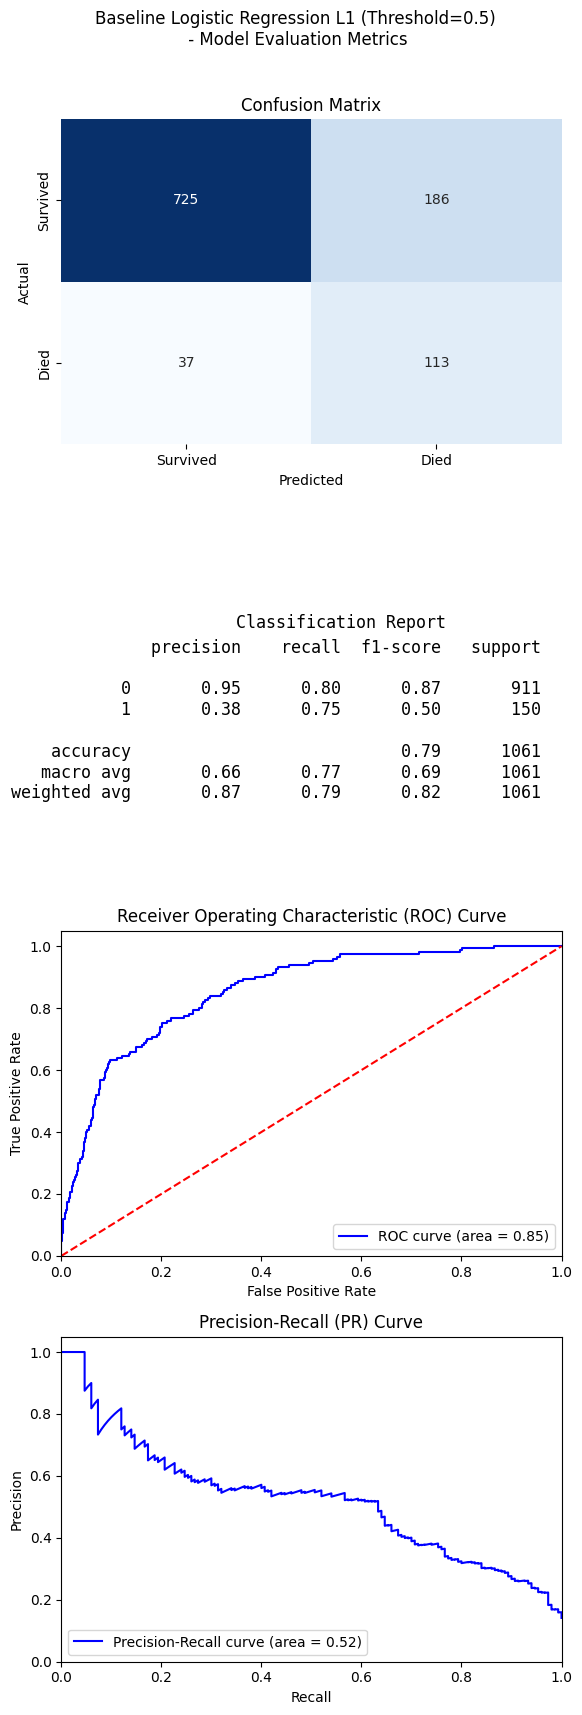

In [59]:
# Evaluate the model performance
util.evaluate_classification_model(y_prob_test, 0.5, y_test, model_name='Baseline Logistic Regression L1')

In [60]:
util.threshold_analysis(y_prob_test, y_test, threshold_range=np.arange(0.5, 0.6, 0.1))

Threshold 0.500 -> Recall: 0.753, FPR: 0.204, Precision: 0.378


## Feature Importance

In [61]:
# Feature Importance from Logistic Regression with L1 Regularization
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logreg_l1.coef_.flatten()})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
print(coef_df)


              feature      coef  abs_coef
21           GCS_last -0.971454  0.971454
72         HCO3_first  0.594474  0.594474
104  MechVentDuration  0.575789  0.575789
109   RespRate_tested -0.570162  0.570162
58   NIDiasABP_median -0.566966  0.566966
..                ...       ...       ...
112        AST_tested  0.000000  0.000000
115    DiasABP_tested  0.000000  0.000000
114  Bilirubin_tested  0.000000  0.000000
110        ALP_tested  0.000000  0.000000
122     SysABP_tested  0.000000  0.000000

[125 rows x 3 columns]


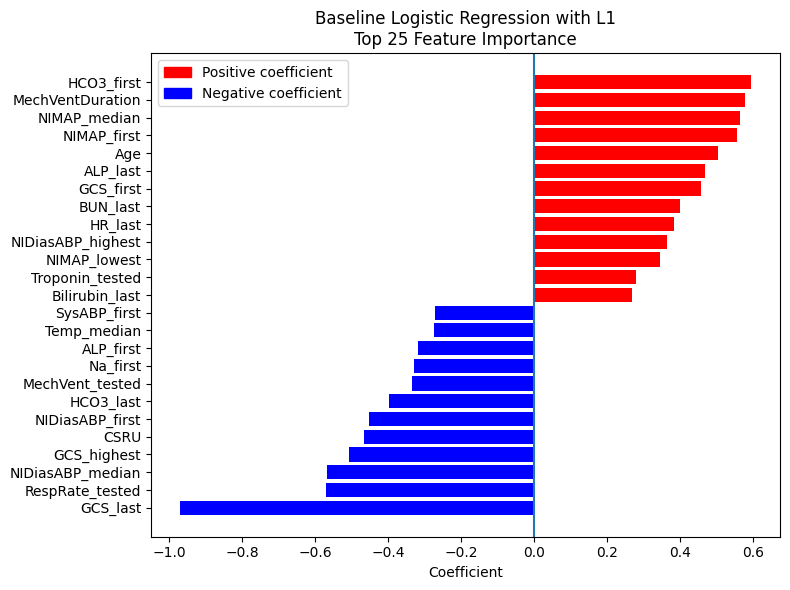

In [62]:
# Plot Top 25 Features
util.plot_top25_feature_importance(coef_df, model_name='Baseline Logistic Regression with L1')

**Zero Coefficient Features**

In [63]:
# Filter features that have zero coefficients
zero_coef_baseline=util.zero_coefficient_features(coef_df)
print('Number of features with zero coefficients:', len(zero_coef_baseline))
print(zero_coef_baseline)

Number of features with zero coefficients: 14
['ALP_tested', 'ALT_last', 'AST_tested', 'Bilirubin_tested', 'DiasABP_tested', 'Glucose_highest', 'NIDiasABP_last', 'SICU', 'SaO2_median', 'SysABP_lowest', 'SysABP_tested', 'Temp_highest', 'WBC_last', 'Weight_first']


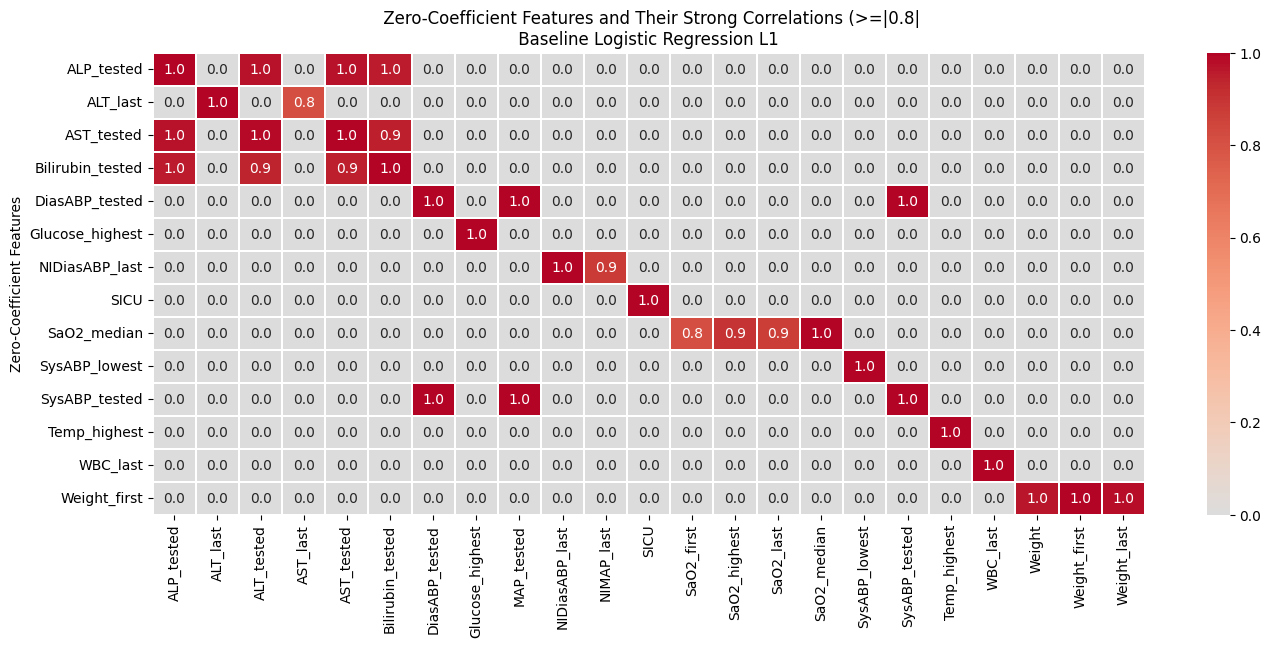

In [64]:
# Visualize zero coefficient features with high correlation features
util.zero_coef_features_heatmap(X_train, zero_coef_baseline, 0.8, model_name='Baseline Logistic Regression L1')

In [65]:
# Zero coefficient features with their high correlation pairs and their coefficients
baseline_high_corr_df_zero_coef=util.high_correlation_pairs_zero_coefficient_features(X_train, coef_df, correlation_threshold=0.8)
print('Number of zero coefficient features with high correlation pairs:', len(baseline_high_corr_df_zero_coef))
baseline_high_corr_df_zero_coef

Number of zero coefficient features with high correlation pairs: 16


Feature_1         Feature_2  Correlation    Coef_1    Coef_2
7       ALP_tested        ALT_tested     0.974579  0.000000  0.121969
6       ALP_tested        AST_tested     0.976259  0.000000  0.000000
9       ALP_tested  Bilirubin_tested     0.958874  0.000000  0.000000
34        ALT_last          AST_last     0.812753  0.000000  0.038801
4       ALT_tested        AST_tested     0.990136  0.121969  0.000000
12      ALT_tested  Bilirubin_tested     0.943250  0.121969  0.000000
10      AST_tested  Bilirubin_tested     0.948201  0.000000  0.000000
2   DiasABP_tested        MAP_tested     0.993196  0.000000 -0.170883
1   DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000
3       MAP_tested     SysABP_tested     0.993196 -0.170883  0.000000
20  NIDiasABP_last        NIMAP_last     0.882597  0.000000 -0.024165
31      SaO2_first       SaO2_median     0.818672  0.020765  0.000000
17    SaO2_highest       SaO2_median     0.904757  0.095557  0.000000
23       SaO2_last       SaO2_median     0.874215 -0.118080  0.000000
8           Weight      Weight_first     0.967867 -0.149171  0.000000
5     Weight_first       Weight_last     0.978571  0.000000 -0.130751

In [66]:
# Remove zero coefficient Features due to high correlation and redundancy
logreg_l1_remove_features=util.zero_coef_remove_features(baseline_high_corr_df_zero_coef)
print('Number of features to remove due to high correlation and zero coefficients:', len(logreg_l1_remove_features))
print(logreg_l1_remove_features)

Number of features to remove due to high correlation and zero coefficients: 9
['ALP_tested', 'ALT_last', 'AST_tested', 'Bilirubin_tested', 'DiasABP_tested', 'NIDiasABP_last', 'SaO2_median', 'SysABP_tested', 'Weight_first']


## Baseline Model - (Logistic Regression L1-regularized) Summary

1. **Logistic Regression with L1 Regularization (Baseline)**
    - The baseline model was trained on **all original features** after missing data imputation.
    - **Performance Metrics**:
        - Recall: 0.75 (113/150)
        - Precision: 0.38 (113/299)
        - False Positive Rate: 0.20 (186/911)
        - Accuracy: 0.79 (838/1061)
   - **Interpretation**:
        - The model correctly identifies **75% of non-survived patients**, missing the remaining 25%.  
        - A **20% false positive rate** indicates that one in five survived patients were incorrectly flagged as non-survived.

2. **Features**
    - **Feature Importance**:
        - Among the top 25 features, `GCS`, `MechVentDuration`, and `BUN_last` consistently show high importance, aligning with earlier feature-to-outcome correlation analysis.
        - Although `NIDiasABP_first` and `NIDiasABP_highest` had p-values >= 0.05 and negligible effect sizes in Mann–Whitney tests, they are among the top features in the model. This highlights that ICU outcomes depend on multiple interacting covariates, rather than being driven by any single feature.
        - `GCS_last` has the most negative coefficient, indicating that higher neurological scores are associated with lower predicted risk of non-survival.
        - `Age` has one of the highest positive coefficients, indicating increased risk of non-survival with increasing age, consistent with a positive linear relationship to the outcome.
    - **Features with Zero Coefficients**:
        - 14 features have zero coefficients; 9 of these are highly correlated (r > 0.8) with other features.
        - These redundant features can be considered for removal during feature engineering to reduce multicollinearity without affecting performance.

**Next steps**: Feature engineering and dimensionality reduction to improve performance and interpretability.



# Feature Engineering

**Clinical Indicator**

In [67]:
# Additional Clinical Features for BMI and BUN/Creatinine Ratio
def clinical_feature(df,new_column, column1, column2):
    if column2=='Height':
        df[new_column + '_first'] = df[column1 + '_first'] / df[column2]
        df[new_column + '_last'] = df[column1 + '_last'] / df[column2]
    else:
        df[new_column + '_first'] = df[column1 + '_first'] / df[column2 + '_first']
        df[new_column + '_last'] = df[column1 + '_last'] / df[column2 + '_last']
    return df
X_train = clinical_feature(X_train, 'BUN_Creatinine_Ratio', 'BUN', 'Creatinine')
X_test = clinical_feature(X_test, 'BUN_Creatinine_Ratio', 'BUN', 'Creatinine')
X_train = clinical_feature(X_train, 'BMI', 'Weight', 'Height')
X_test = clinical_feature(X_test, 'BMI', 'Weight', 'Height')

In [68]:
# Add Number of Kidney Panels Tests Feature
X_train['Number_Kidney_Panels_Tested'] = X_train[['ALT_tested', 'ALP_tested','AST_tested','Bilirubin_tested']].sum(axis=1).astype(int)
print('Train Data:', X_train['Number_Kidney_Panels_Tested'].value_counts())

X_test['Number_Kidney_Panels_Tested'] = X_test[['ALT_tested', 'ALP_tested','AST_tested','Bilirubin_tested']].sum(axis=1).astype(int)
print('Test Data:', X_test['Number_Kidney_Panels_Tested'].value_counts())

Train Data: Number_Kidney_Panels_Tested
0    1362
4    1033
3      31
1      27
2      20
Name: count, dtype: int64
Test Data: Number_Kidney_Panels_Tested
0    577
4    442
1     18
3     17
2      7
Name: count, dtype: int64


**Temporal Features**

In [69]:
# Temporal Feature Engineering
def feature_engineer_temporal(df,column_name, high_low=False):
    df[column_name+'_delta'] = df[column_name+'_last'] - df[column_name+'_first']
    df[column_name+'_ratio'] = df[column_name+'_last'] / df[column_name+'_first']
    if high_low:
        df[column_name+'_range'] = df[column_name+'_highest'] - df[column_name+'_lowest']
        df[column_name+'_HighLow_ratio'] = df[column_name+'_highest'] / df[column_name+'_lowest']
    return df

In [70]:
for name in ['ALP', 'ALT', 'AST', 'Albumin', 'BUN','Bilirubin', 'Creatinine','DiasABP', 'FiO2','GCS','Glucose', 'HCO3','HCT','HR','K','Lactate', 'MAP', 'Mg','NIDiasABP','NIMAP','NISysABP','Na','PaCO2','Platelets','SaO2', 'SysABP','Temp', 'Weight', 'pH','BMI','BUN_Creatinine_Ratio']:
    high_low = True if name in ['DiasABP', 'GCS', 'Glucose','HR', 'MAP','NIDiasABP','NIMAP','NISysABP','SaO2', 'SysABP','Temp'] else False
    X_train = feature_engineer_temporal(X_train, name, high_low)
    X_test = feature_engineer_temporal(X_test, name, high_low)

**Removel Features**

In [71]:
# Remove static features that is patient specific
patient_specific_features=['Weight','Weight_first','Weight_last','Height']
X_train=X_train.drop(columns=patient_specific_features, axis=1)
X_test=X_test.drop(columns=patient_specific_features, axis=1)

In [72]:
# Remove Zero Coefficient Features and highly correlated features with other features
remove_features=[f for f in logreg_l1_remove_features if f in X_train.columns]
print('Removing features:', remove_features)
X_train=X_train.drop(columns=remove_features, axis=1)
X_test=X_test.drop(columns=remove_features, axis=1)

Removing features: ['ALP_tested', 'ALT_last', 'AST_tested', 'Bilirubin_tested', 'DiasABP_tested', 'NIDiasABP_last', 'SaO2_median', 'SysABP_tested']


In [73]:
print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

Train data shape: (2473, 202)
Test data shape: (1061, 202)


## Feature Engineering Summary

1. **Clinical Indicators**
   - `BMI`: Weight / Height; captures patient body mass index.  
   - `BUN_Creatinine_Ratio`: BUN / Creatinine; reflects kidney function and may indicate dehydration or liver dysfunction.  
   - `Number_Kidney_Panels_Tested`: Total number of kidney-related tests; summarizes test frequency and may reflect patient severity while avoiding redundant correlated tests.

2. **Temporal Features**
   - `*_delta`: Last - First; measures absolute change over time to indicate deterioration or recovery.  
   - `*_ratio`: Last / First; measures relative change since ICU admission.  
   - `*_range`: Highest - Lowest; measures total variation during ICU stay.  
   - `*_HighLow_ratio`: Highest / Lowest; measures relative volatility from highest to lowest measurement.

3. **Removed Features**
   - **Static patient-specific measurements**: `Weight`, `Height` removed to avoid redundancy.  
   - **Redundant baseline features**: 9 features with zero coefficients in the baseline model and highly correlated (>0.8) with other features were removed to reduce multicollinearity.

**Next steps**: Modeling using both raw and engineered features.


# Feature-Engineered Models

## Logistic Regression Model

In [74]:
# Features scaling
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


# Add the feature names back to scaled data
X_train_scaled_df=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df=pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [75]:
#---------------
# Model Training with Hyperparameter Tuning
#---------------

cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {'C': [0.01, 0.1, 0.5, 1],
              'class_weight': [None, 'balanced']}


logred_grid = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'), param_grid, scoring='average_precision', cv=cv)
logred_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 0.5, 1],
                         'class_weight': [None, 'balanced']},
             scoring='average_precision')

In [76]:
print('Number of iterations:', logred_grid.best_estimator_.n_iter_[0])

Number of iterations: 14


In [77]:
logred_fe_model=logred_grid.best_estimator_
print('Best hyperparameter C:', logred_grid.best_params_)

Best hyperparameter C: {'C': 0.1, 'class_weight': None}


In [78]:
# Predictions Probability
y_prob_test_logreg_fe=logred_fe_model.predict_proba(X_test_scaled)[:,1]

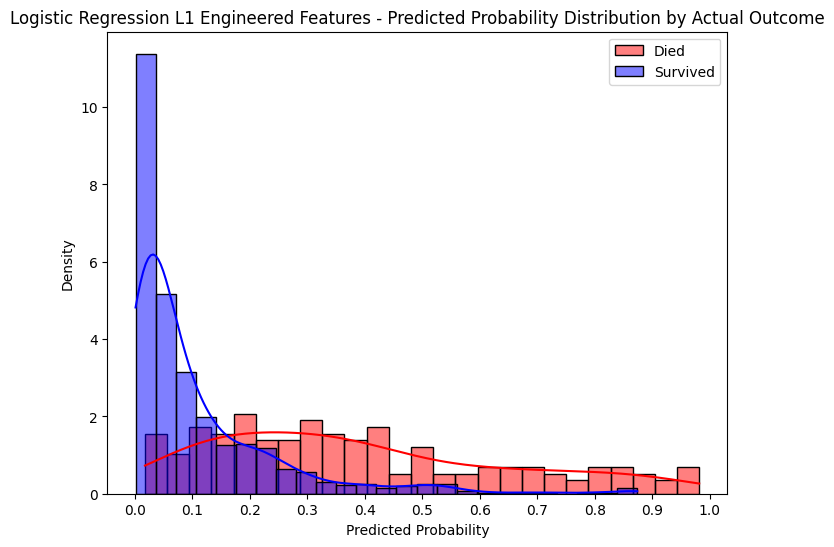

In [79]:
# Visualize Threshold Distribution
util.plot_threshold_distribution(y_prob_test_logreg_fe, y_test, model_name='Logistic Regression L1 Engineered Features')

In [80]:
# Evaluate threshold at different levels
util.threshold_analysis(y_prob_test_logreg_fe, y_test, threshold_range=np.arange(0.1, 0.5, 0.01)) 

Threshold 0.100 -> Recall: 0.893, FPR: 0.330, Precision: 0.308
Threshold 0.110 -> Recall: 0.873, FPR: 0.305, Precision: 0.320
Threshold 0.120 -> Recall: 0.867, FPR: 0.280, Precision: 0.338
Threshold 0.130 -> Recall: 0.853, FPR: 0.257, Precision: 0.354
Threshold 0.140 -> Recall: 0.827, FPR: 0.244, Precision: 0.358
Threshold 0.150 -> Recall: 0.807, FPR: 0.225, Precision: 0.371
Threshold 0.160 -> Recall: 0.793, FPR: 0.216, Precision: 0.377
Threshold 0.170 -> Recall: 0.773, FPR: 0.205, Precision: 0.383
Threshold 0.180 -> Recall: 0.753, FPR: 0.194, Precision: 0.390
Threshold 0.190 -> Recall: 0.720, FPR: 0.183, Precision: 0.393
Threshold 0.200 -> Recall: 0.700, FPR: 0.168, Precision: 0.407
Threshold 0.210 -> Recall: 0.693, FPR: 0.156, Precision: 0.423
Threshold 0.220 -> Recall: 0.693, FPR: 0.143, Precision: 0.444
Threshold 0.230 -> Recall: 0.680, FPR: 0.127, Precision: 0.468
Threshold 0.240 -> Recall: 0.667, FPR: 0.120, Precision: 0.478
Threshold 0.250 -> Recall: 0.640, FPR: 0.108, Precision

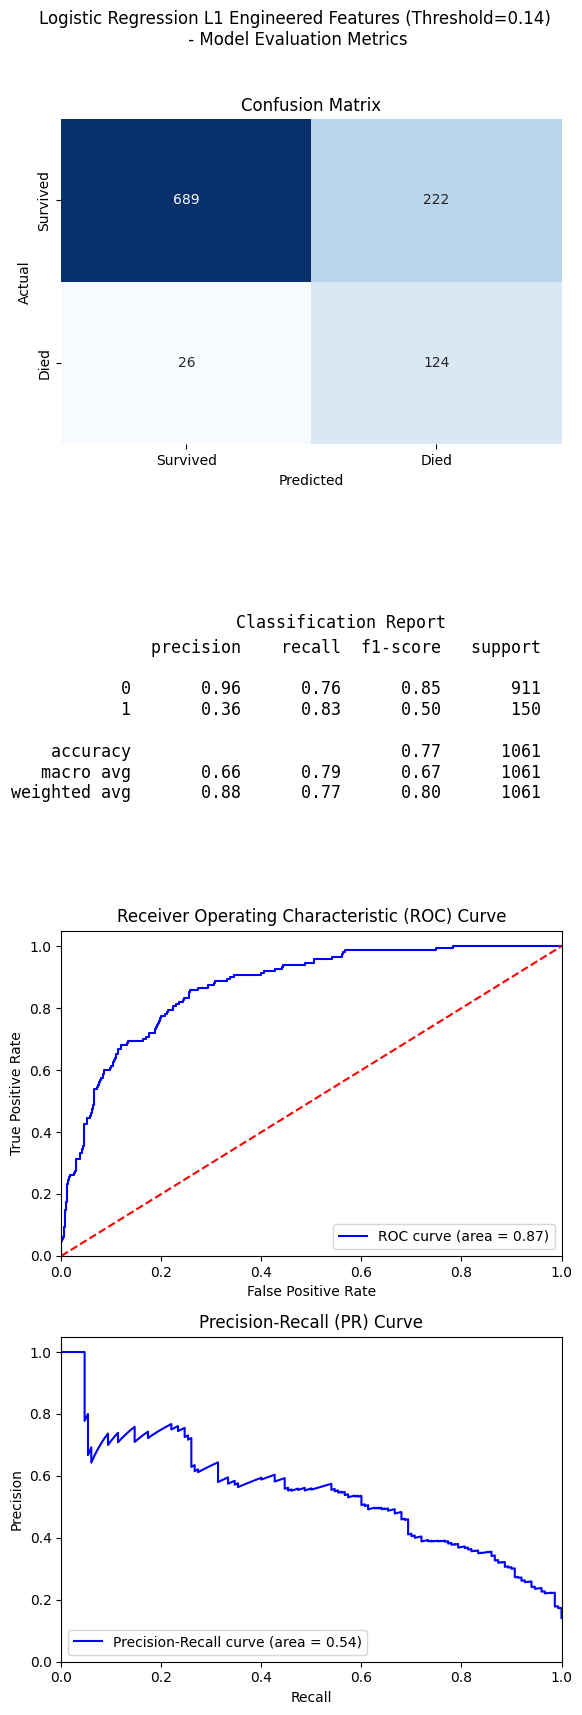

In [81]:
# Evaluate the model performance
logred_grid_fe_threshold=0.14
util.evaluate_classification_model(y_prob_test_logreg_fe, logred_grid_fe_threshold, y_test, model_name='Logistic Regression L1 Engineered Features')

### Feature Importance

In [82]:
# Feature Importance from Logistic Regression with L1 Regularization
coef_df_logreg_fe = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logred_fe_model.coef_[0]})
coef_df_logreg_fe['abs_coef'] = coef_df_logreg_fe['coef'].abs()
coef_df_logreg_fe.sort_values('abs_coef', ascending=False, inplace=True)
coef_df_logreg_fe.head(25)

feature      coef  abs_coef
19                    GCS_last -0.448775  0.448775
102            RespRate_tested -0.338147  0.338147
5                         CSRU -0.298897  0.298897
2                          Age  0.296871  0.296871
138                  GCS_delta -0.275243  0.275243
40                 GCS_highest -0.258431  0.258431
59                 Temp_median -0.243657  0.243657
116                   BMI_last -0.212656  0.212656
146                 HCO3_delta -0.204864  0.204864
21                     HR_last  0.194655  0.194655
97            MechVentDuration  0.191122  0.191122
100            Troponin_tested  0.183840  0.183840
83              Bilirubin_last  0.156774  0.156774
89                Lactate_last  0.154840  0.154840
20                Glucose_last  0.144524  0.144524
73                    Na_first -0.136720  0.136720
82                    BUN_last  0.133747  0.133747
114  BUN_Creatinine_Ratio_last  0.120150  0.120150
90                     Mg_last  0.109539  0.109539
137                 FiO2_ratio  0.107765  0.107765
181            Platelets_ratio  0.101994  0.101994
42                  HR_highest  0.089152  0.089152
55            NIDiasABP_median -0.081496  0.081496
38                 Temp_lowest -0.080312  0.080312
0                       SAPS-I  0.078803  0.078803

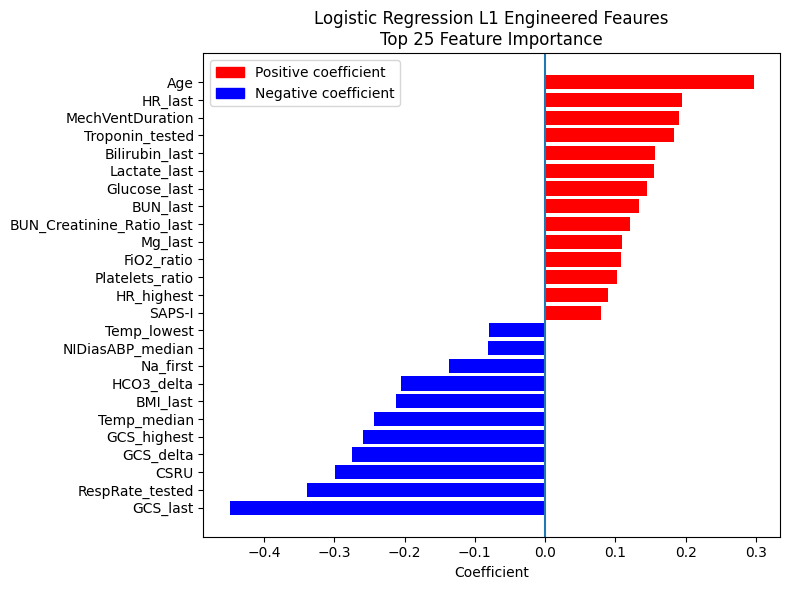

In [83]:
# Top 25 Features
util.plot_top25_feature_importance(coef_df_logreg_fe, model_name='Logistic Regression L1 Engineered Feaures')

In [84]:
# Filter features that have zero coefficients
zero_coef_LogReg_fe=util.zero_coefficient_features(coef_df_logreg_fe)
print('Number of features with zero coefficients after feature engineering:', len(zero_coef_LogReg_fe))
print(zero_coef_LogReg_fe)

Number of features with zero coefficients after feature engineering: 135
['ALP_first', 'ALP_ratio', 'ALT_delta', 'ALT_first', 'ALT_ratio', 'AST_delta', 'AST_last', 'Albumin_first', 'Albumin_last', 'Albumin_ratio', 'Albumin_tested', 'BMI_delta', 'BMI_first', 'BUN_Creatinine_Ratio_delta', 'BUN_Creatinine_Ratio_first', 'BUN_Creatinine_Ratio_ratio', 'BUN_first', 'BUN_ratio', 'Bilirubin_delta', 'Bilirubin_first', 'Bilirubin_ratio', 'CCU', 'Cholesterol_tested', 'Creatinine_delta', 'Creatinine_first', 'Creatinine_last', 'Creatinine_ratio', 'DiasABP_HighLow_ratio', 'DiasABP_delta', 'DiasABP_first', 'DiasABP_highest', 'DiasABP_last', 'DiasABP_lowest', 'DiasABP_median', 'DiasABP_range', 'FiO2_delta', 'FiO2_first', 'FiO2_last', 'FiO2_tested', 'GCS_first', 'GCS_lowest', 'GCS_median', 'GCS_range', 'GCS_ratio', 'Glucose_HighLow_ratio', 'Glucose_delta', 'Glucose_first', 'Glucose_highest', 'Glucose_range', 'Glucose_ratio', 'HCO3_first', 'HCO3_last', 'HCO3_ratio', 'HCT_delta', 'HCT_last', 'HCT_ratio', 

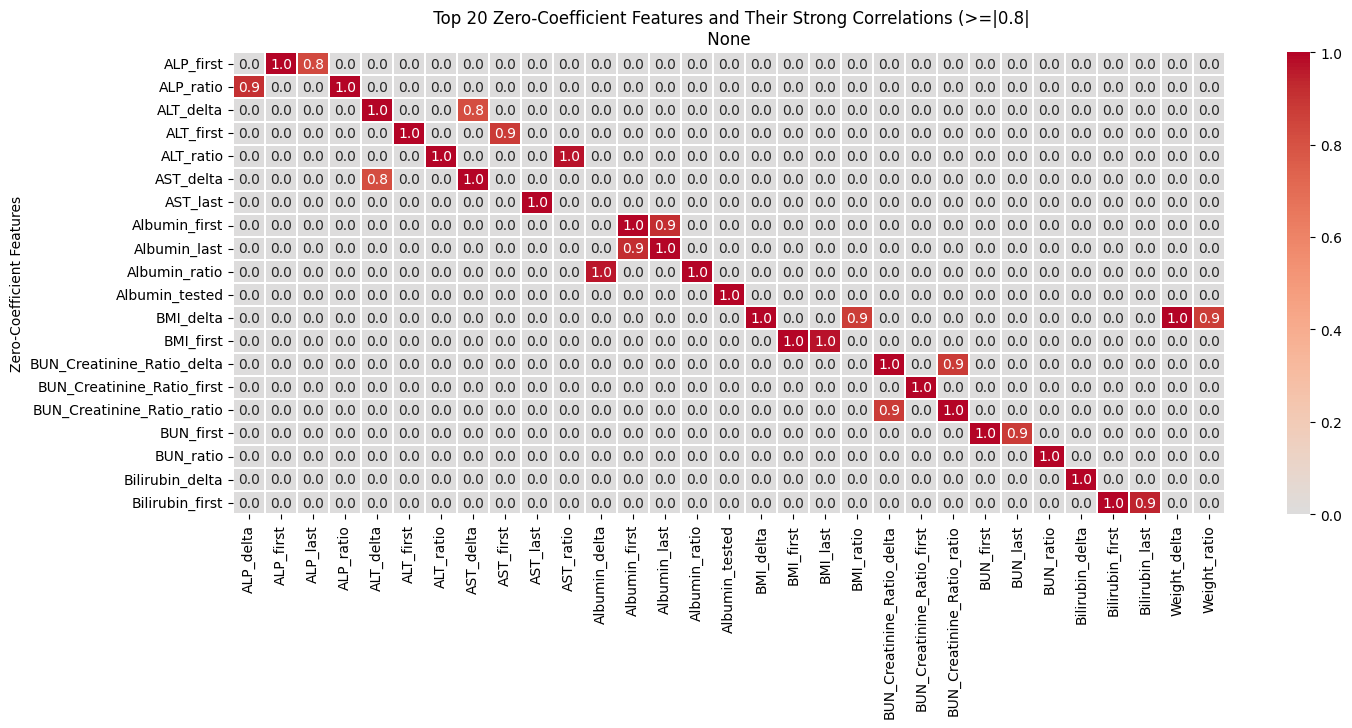

In [85]:
# Top 20 Zero Coefficient Features Heatmap and their high correlation pairs
util.zero_coef_features_heatmap(X_train, zero_coef_LogReg_fe, correlation_threshold=0.8, top_n=20, model_name=None)

In [86]:
# Zero coefficient features with their high correlation pairs and their coefficients
high_corr_df_zero_coef_LogReg_ef=util.high_correlation_pairs_zero_coefficient_features(X_train, coef_df_logreg_fe, correlation_threshold=0.8)
high_corr_df_zero_coef_LogReg_ef

Feature_1     Feature_2  Correlation    Coef_1    Coef_2
31           ALP_delta     ALP_ratio     0.906257  0.042404  0.000000
56           ALP_first      ALP_last     0.829731  0.000000  0.069795
60           ALT_delta     AST_delta     0.818627  0.000000  0.000000
41           ALT_first     AST_first     0.878810  0.000000 -0.042087
11           ALT_ratio     AST_ratio     0.973443  0.000000  0.059279
..                 ...           ...          ...       ...       ...
6   Temp_HighLow_ratio    Temp_range     0.996103  0.000000  0.000000
3           Temp_delta    Temp_ratio     0.998501  0.000000  0.000000
68          Temp_first    Temp_ratio    -0.801413  0.000000  0.000000
39        Weight_delta  Weight_ratio     0.881076  0.000000 -0.002608
2             pH_delta      pH_ratio     0.999735  0.000000  0.000000

[75 rows x 5 columns]

In [87]:
# Zero coefficient features with high correlation pairs for potential removal
logreg_fe_remove_features=util.zero_coef_remove_features(high_corr_df_zero_coef_LogReg_ef)
print('Number of features to potentially remove due to high correlation and zero coefficients after feature engineering:', len(logreg_fe_remove_features))
print(logreg_fe_remove_features)

Number of features to potentially remove due to high correlation and zero coefficients after feature engineering: 61
['ALP_first', 'ALP_ratio', 'ALT_first', 'ALT_ratio', 'AST_delta', 'Albumin_first', 'Albumin_ratio', 'BMI_delta', 'BMI_first', 'BUN_Creatinine_Ratio_ratio', 'BUN_first', 'Bilirubin_first', 'Creatinine_first', 'DiasABP_delta', 'DiasABP_highest', 'FiO2_delta', 'FiO2_first', 'FiO2_tested', 'GCS_lowest', 'GCS_median', 'GCS_range', 'GCS_ratio', 'Glucose_first', 'Glucose_highest', 'Glucose_range', 'HCO3_ratio', 'HCT_ratio', 'HR_HighLow_ratio', 'HR_ratio', 'K_ratio', 'MAP_highest', 'Mg_delta', 'NIDiasABP_delta', 'NIDiasABP_highest', 'NIDiasABP_ratio', 'NIMAP_delta', 'NIMAP_first', 'NIMAP_highest', 'NIMAP_last', 'NIMAP_lowest', 'NIMAP_median', 'NIMAP_range', 'NISysABP_delta', 'NISysABP_first', 'NISysABP_highest', 'NISysABP_lowest', 'NISysABP_median', 'NISysABP_ratio', 'Na_ratio', 'Number_Kidney_Panels_Tested', 'PaCO2_delta', 'Platelets_first', 'SaO2_lowest', 'SaO2_range', 'SaO2_r

## XGBoost

In [88]:
# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

In [89]:
# XGBoost with hyperparameter tuning using grid search and cross-validation
def run_xgb_tuned_grid(param_grid, dtrain):

    xgb_grid_results = []

    # Grid Loop
    for params in ParameterGrid(param_grid):
        # Static parameters
        params.update({
            'objective': 'binary:logistic',
            'eval_metric': 'aucpr', # Using PR-AUC for imbalance
            'tree_method': 'exact', 
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        })
        
        cv_hist = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,   # Set high, early stopping will cut it short
            nfold=5,              
            stratified=True,
            early_stopping_rounds=20, # Stop if no improvement in 20 trees
            #verbose_eval=50,
            as_pandas=True,
            seed=RANDOM_STATE
        )
        
        # Extract the best average PR-AUC and the iteration it occurred
        best_aucpr = cv_hist['test-aucpr-mean'].max()
        best_n_estimators = cv_hist.shape[0]
        
        xgb_grid_results.append({
            **params,
            'mean_pr_auc': best_aucpr,
            'optimal_trees': best_n_estimators
        })

    # Results DataFrame
    xgb_grid_df = pd.DataFrame(xgb_grid_results).sort_values('mean_pr_auc', ascending=False)

    return xgb_grid_df


In [90]:
# --------------------
# Stage 1 Hyperparameter Grid Search
# --------------------

pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()

param_grid_stage1 = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.07],
    'min_child_weight': [1, 5],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1, pos_ratio*0.5, pos_ratio, pos_ratio*1.25] 
}

# Run XGBoost Grid Search - Stage 1
xgb_grid_stage1_df = run_xgb_tuned_grid(param_grid_stage1, dtrain)


In [91]:
# Top 5 Stage 1 XGBoost Hyperparameter Combinations
print(xgb_grid_stage1_df.head(5))

     colsample_bytree  learning_rate  max_depth  min_child_weight  \
204               0.5           0.07          5                 5   
424               0.7           0.07          5                 5   
336               0.7           0.05          5                 1   
135               0.5           0.05          5                 5   
327               0.7           0.05          4                 5   

     scale_pos_weight  subsample        objective eval_metric tree_method  \
204          1.000000        0.5  binary:logistic       aucpr       exact   
424          3.022792        0.7  binary:logistic       aucpr       exact   
336          1.000000        0.5  binary:logistic       aucpr       exact   
135          3.022792        0.5  binary:logistic       aucpr       exact   
327          3.022792        0.5  binary:logistic       aucpr       exact   

     random_state  n_jobs  mean_pr_auc  optimal_trees  
204            42      -1     0.503390             83  
424       

In [92]:
# --------------------
# Stage 2 Hyperparameter Grid Search
# --------------------

param_grid_stage2 = {
    'max_depth': [5], 
    'learning_rate': [0.05, 0.06, 0.07],
    'subsample': [0.5, 0.6],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'min_child_weight': [5, 8, 10], 
    'reg_lambda': [1, 5, 10],      # L2: Penalizes large weights
    'reg_alpha': [0.1, 1, 2],      # L1: Feature selection (zeros out noise)
    'scale_pos_weight': [1, pos_ratio*0.5],
    'gamma': [0, 0.2] # prune splits that do not improve performance
}

# Run XGBoost Grid Search - Stage 2
xgb_grid_stage2_df = run_xgb_tuned_grid(param_grid_stage2, dtrain)


In [93]:
print(xgb_grid_stage2_df.head())

      colsample_bytree  gamma  learning_rate  max_depth  min_child_weight  \
795                0.6    0.0           0.06          5                 8   
325                0.5    0.2           0.05          5                 5   
1418               0.7    0.0           0.06          5                 5   
506                0.5    0.2           0.06          5                10   
1082               0.6    0.2           0.06          5                 5   

      reg_alpha  reg_lambda  scale_pos_weight  subsample        objective  \
795         0.1           1          3.022792        0.6  binary:logistic   
325         0.1           1          1.000000        0.6  binary:logistic   
1418        1.0           1          3.022792        0.5  binary:logistic   
506         0.1           1          3.022792        0.5  binary:logistic   
1082        0.1           1          3.022792        0.5  binary:logistic   

     eval_metric tree_method  random_state  n_jobs  mean_pr_auc  optimal_t

In [94]:
# --------------------
# Model Training with Best Hyperparameters from Stage 2
# --------------------

# Best performers from stage 2
xgb_best_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=158, 
    colsample_bytree=0.5,
    subsample=0.6,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    gamma=0.2,
    scale_pos_weight=1,
    objective='binary:logistic',
    tree_method='exact',
    random_state=42
)


xgb_best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=158,
              n_jobs=None, num_parallel_tree=None, ...)

In [95]:
# Predictions Probability
y_xgb_probs = xgb_best_model.predict_proba(X_test)[:, 1]

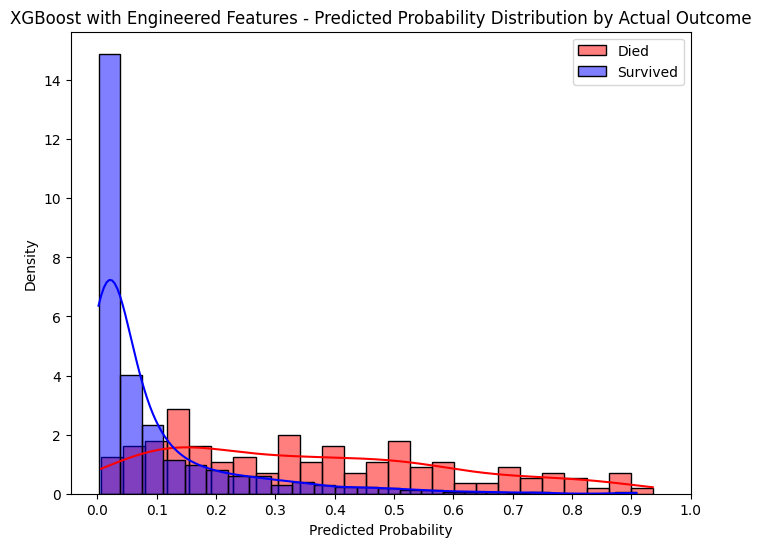

In [96]:
# Visualize threshold distribution
util.plot_threshold_distribution(y_xgb_probs, y_test, model_name='XGBoost with Engineered Features')

In [97]:
# Evaluate threshold at different levels
util.threshold_analysis(y_xgb_probs, y_test, threshold_range=np.arange(0.1, 0.5, 0.01))

Threshold 0.100 -> Recall: 0.847, FPR: 0.252, Precision: 0.356
Threshold 0.110 -> Recall: 0.833, FPR: 0.233, Precision: 0.371
Threshold 0.120 -> Recall: 0.827, FPR: 0.218, Precision: 0.384
Threshold 0.130 -> Recall: 0.787, FPR: 0.205, Precision: 0.387
Threshold 0.140 -> Recall: 0.760, FPR: 0.195, Precision: 0.390
Threshold 0.150 -> Recall: 0.727, FPR: 0.184, Precision: 0.394
Threshold 0.160 -> Recall: 0.707, FPR: 0.171, Precision: 0.405
Threshold 0.170 -> Recall: 0.700, FPR: 0.161, Precision: 0.417
Threshold 0.180 -> Recall: 0.687, FPR: 0.155, Precision: 0.422
Threshold 0.190 -> Recall: 0.667, FPR: 0.147, Precision: 0.427
Threshold 0.200 -> Recall: 0.653, FPR: 0.137, Precision: 0.439
Threshold 0.210 -> Recall: 0.633, FPR: 0.130, Precision: 0.446
Threshold 0.220 -> Recall: 0.627, FPR: 0.124, Precision: 0.454
Threshold 0.230 -> Recall: 0.620, FPR: 0.117, Precision: 0.465
Threshold 0.240 -> Recall: 0.620, FPR: 0.112, Precision: 0.477
Threshold 0.250 -> Recall: 0.600, FPR: 0.109, Precision

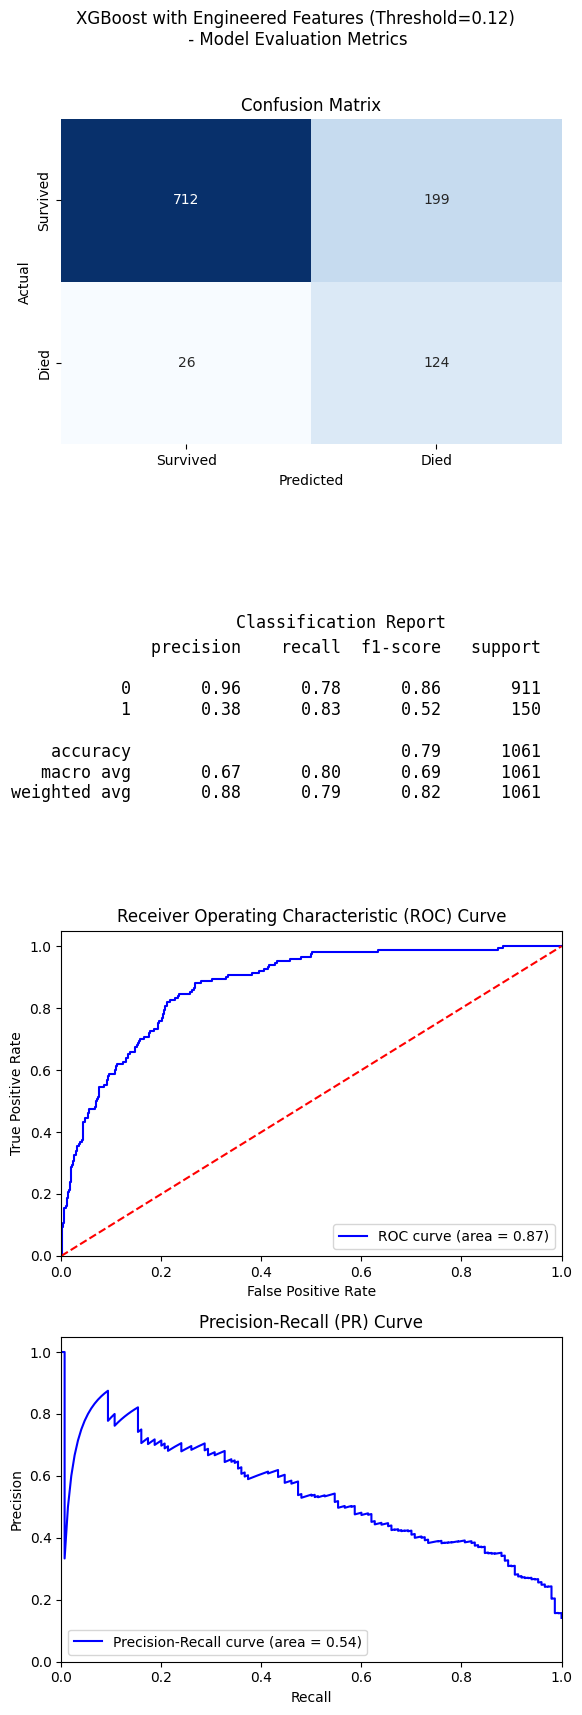

In [98]:
# Evaluate the model performance at specific threshold
xgb_threshold=0.12
util.evaluate_classification_model(y_xgb_probs, xgb_threshold, y_test, model_name='XGBoost with Engineered Features')

### Feature Importance

In [99]:
# Feature Importance from XGBoost
xgb_importance_dict = xgb_best_model.get_booster().get_score(importance_type='gain') # Average gain of splits which use the feature
xgb_importance_df=pd.DataFrame(xgb_importance_dict.items(), columns=['feature', 'gain'])
xgb_importance_df=xgb_importance_df.sort_values(by='gain', ascending=False)

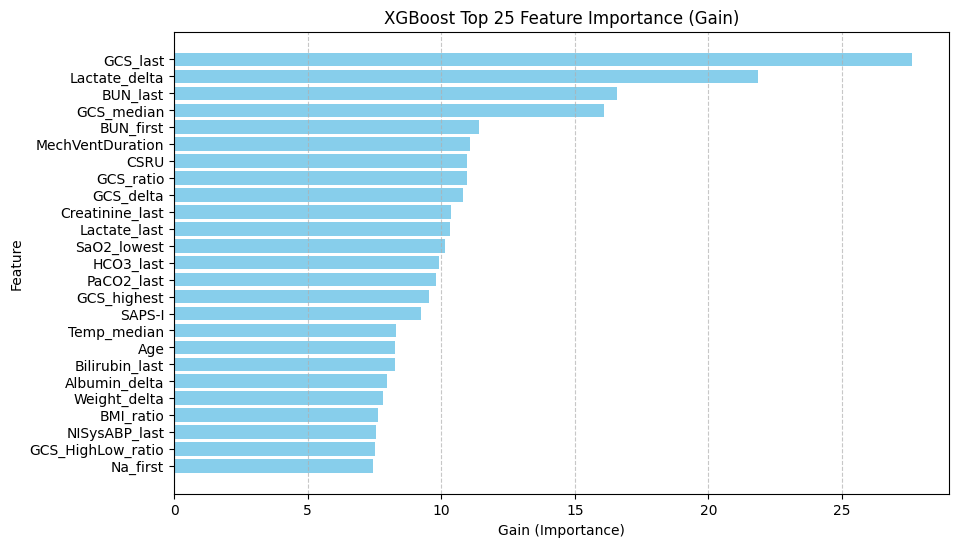

In [100]:
# Plot Top 25 Features Importance
plt.figure(figsize=(10,6))
plt.barh(
xgb_importance_df['feature'].head(25),
xgb_importance_df['gain'].head(25),
color='skyblue')
plt.title(f'XGBoost Top 25 Feature Importance (Gain)')
plt.xlabel('Gain (Importance)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('./results/Xgb_Engineered_Features_top25_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [101]:
# Bottom 10 features from XGBoost feature importance
print(xgb_importance_df.sort_values(by='gain', ascending=True).head(10))

             feature      gain
96        ALT_tested  0.507497
174       SaO2_ratio  2.418319
12    NISysABP_first  2.611104
101  MechVent_tested  2.620179
110        ALP_ratio  2.696031
153         Mg_delta  2.704080
173       SaO2_delta  2.778699
116    Albumin_ratio  2.805116
175     SysABP_delta  2.852334
9          MAP_first  3.020258


### SHAP Summary Plot

In [102]:
# SHAP Values Calculation from  XGBoost Model
explainer=shap.TreeExplainer(xgb_best_model, X_train)
# Compute SHAP values for test set
shap_values_test = explainer(X_test)

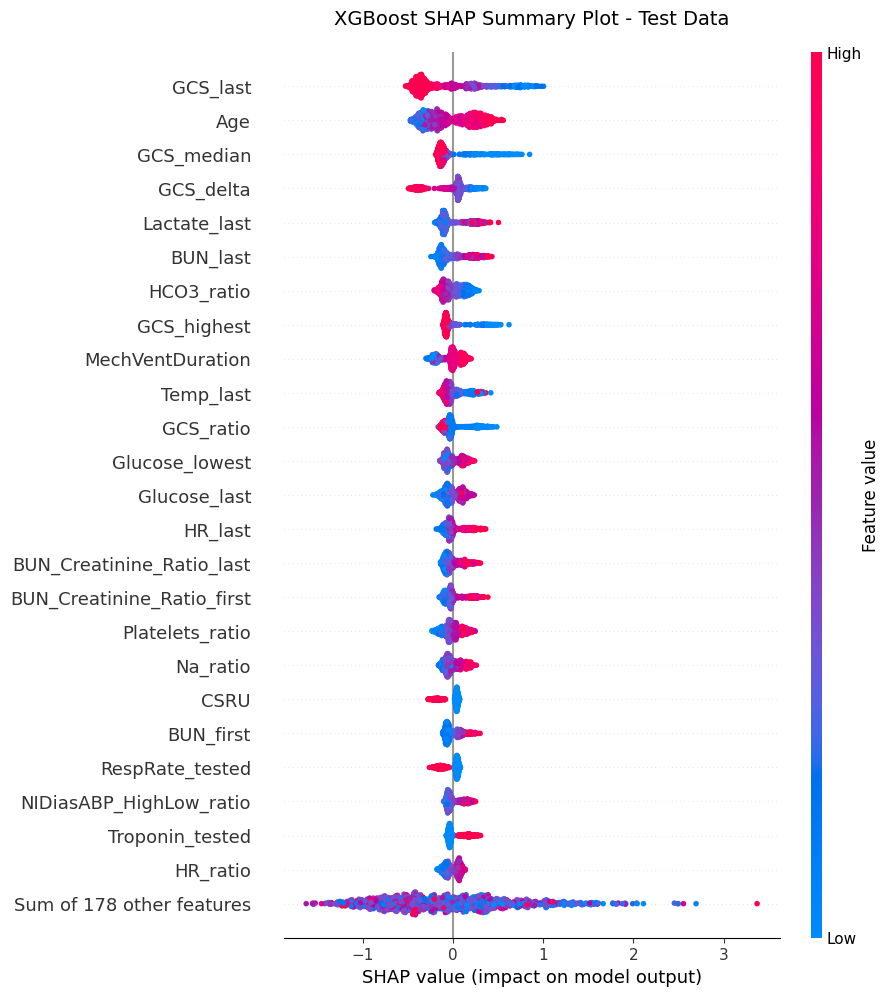

In [103]:
# SHAP Summary Plot
shap.plots.beeswarm(shap_values_test, max_display=25, show=False)
plt.title('XGBoost SHAP Summary Plot - Test Data', fontsize=14, pad=20)
plt.savefig(r'./results/Xgb_Engineered_Features_SHAP_summary_plot.png', dpi=150, bbox_inches='tight')
plt.show()

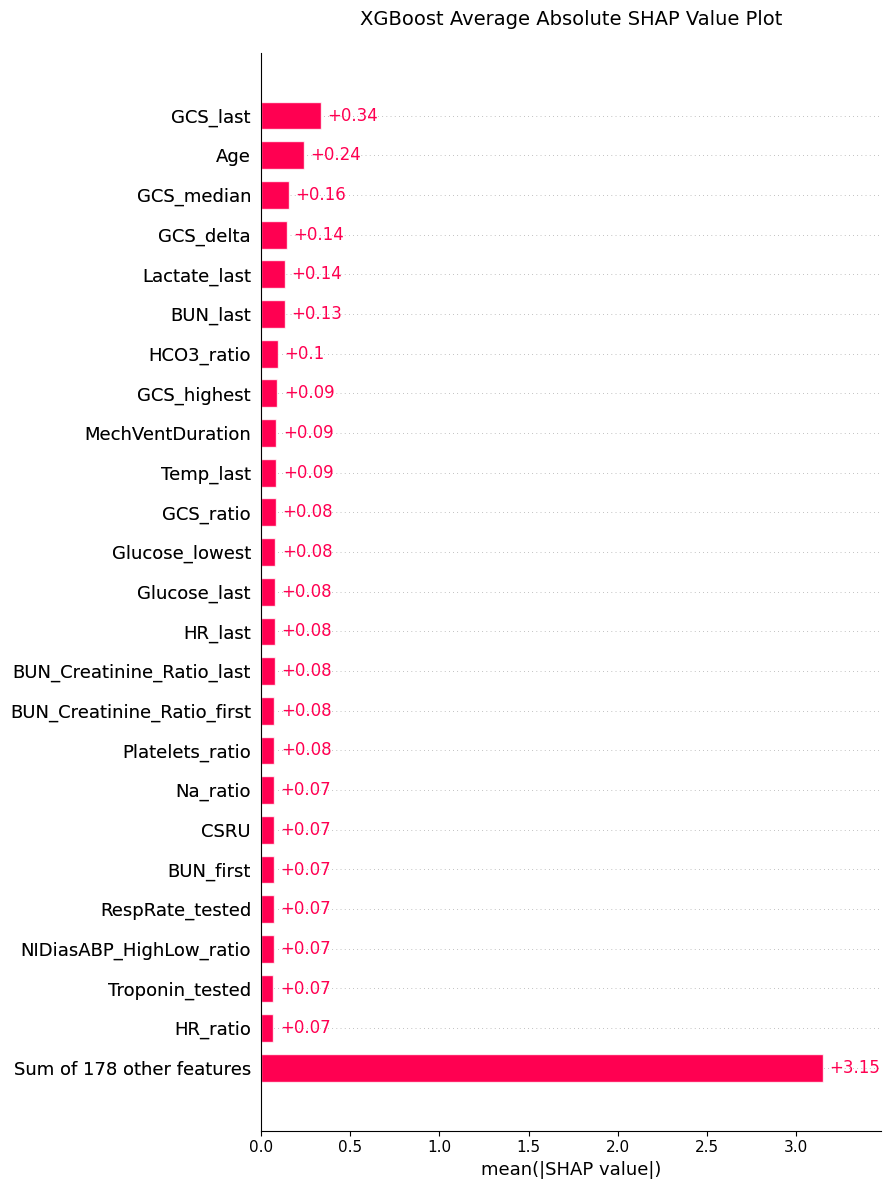

In [104]:
# SHAP Bar Plot
shap.plots.bar(shap_values_test, max_display=25, show=False)
plt.title('XGBoost Average Absolute SHAP Value Plot', fontsize=14, pad=20)
plt.savefig(r'./results/Xgb_Engineered_Features_SHAP_bar_plot.png', dpi=150, bbox_inches='tight')
plt.show()

### SHAP Specific Patient

In [105]:
# XGBoost Predictions at specific threshold
print(xgb_threshold)
y_pred_test_xgb=(y_xgb_probs >=xgb_threshold).astype(int)


0.12


In [106]:
# Test results with true labels, predicted labels, and predicted probabilities  
test_results=pd.DataFrame({'y_true': y_test,'y_pred': y_pred_test_xgb, 'y_prob': y_xgb_probs}).reset_index(drop=True)

false_negative_results=test_results[(test_results['y_true'] ==1) & (test_results['y_pred'] == 0)].index.tolist()
false_positive_results=test_results[(test_results['y_true'] ==0) & (test_results['y_pred'] == 1)].index.tolist()

true_negative_results=test_results[(test_results['y_true'] ==0) & (test_results['y_pred'] == 0)].index.tolist()
true_positive_results=test_results[(test_results['y_true'] ==1) & (test_results['y_pred'] == 1)].index.tolist()


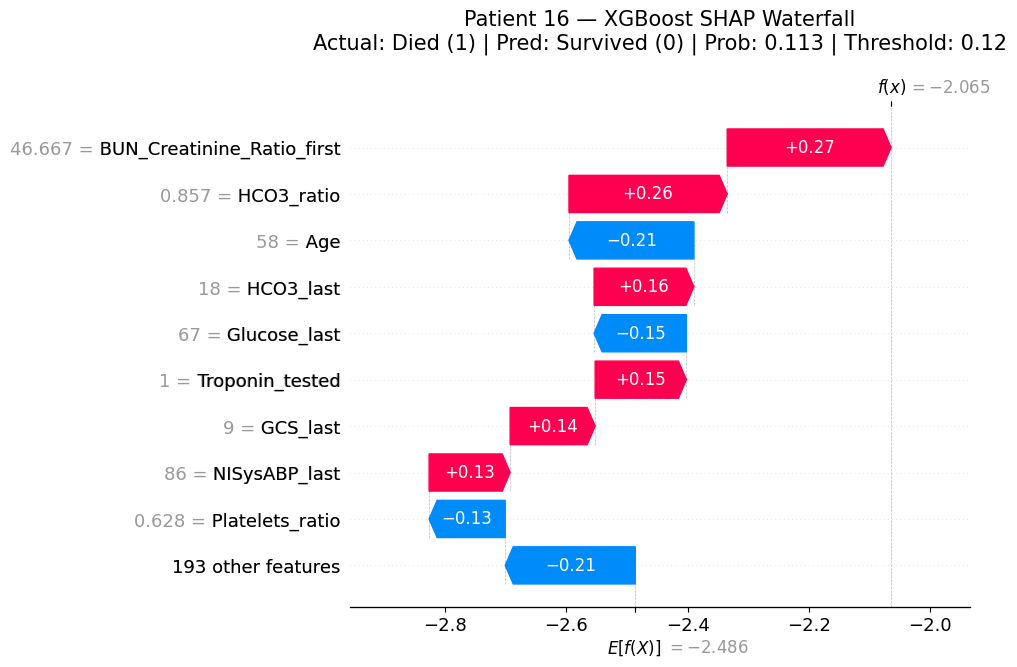

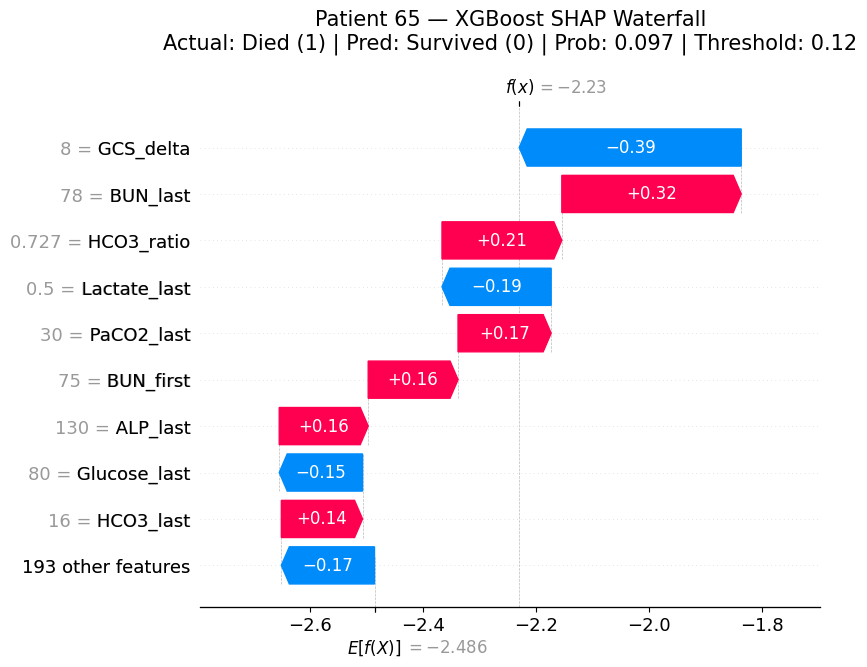

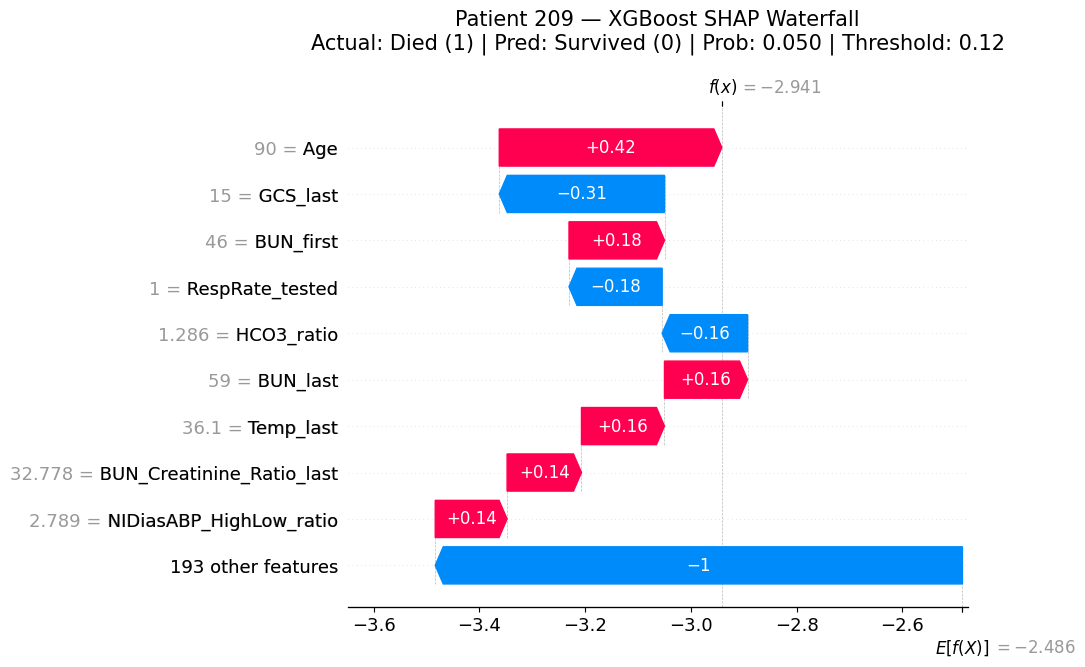

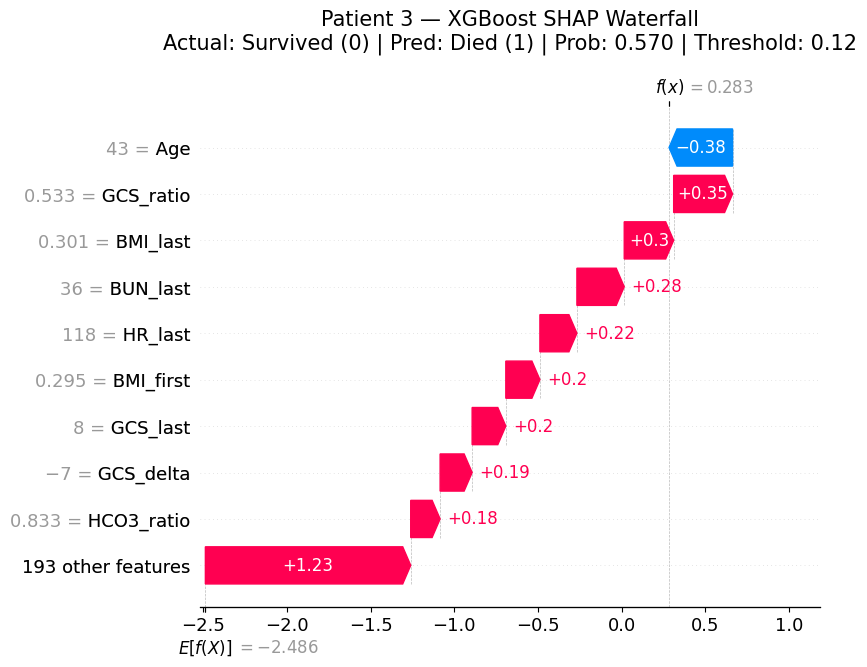

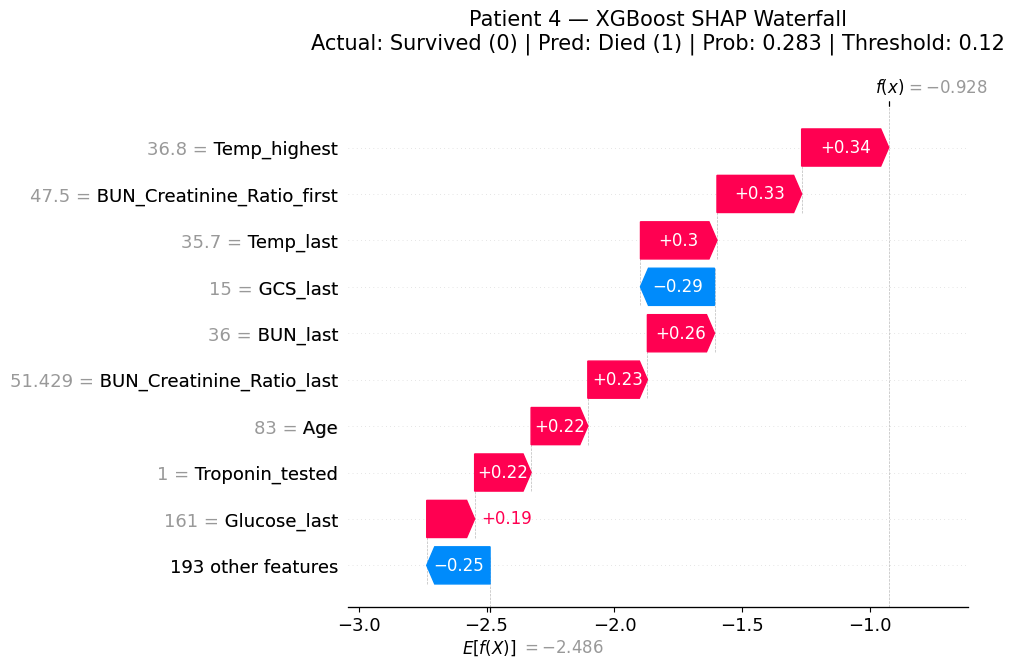

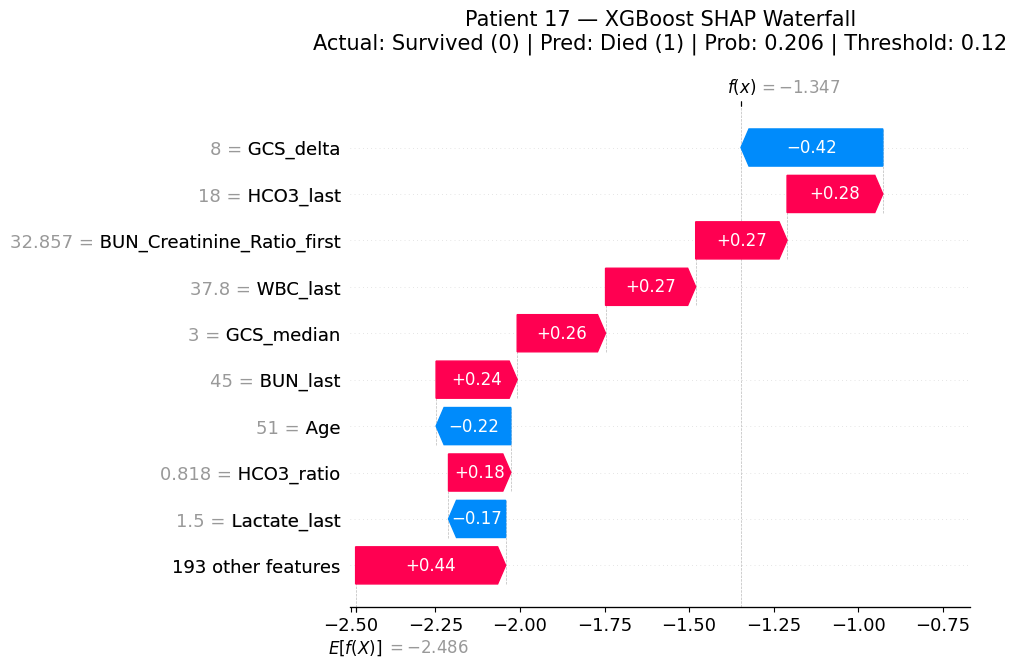

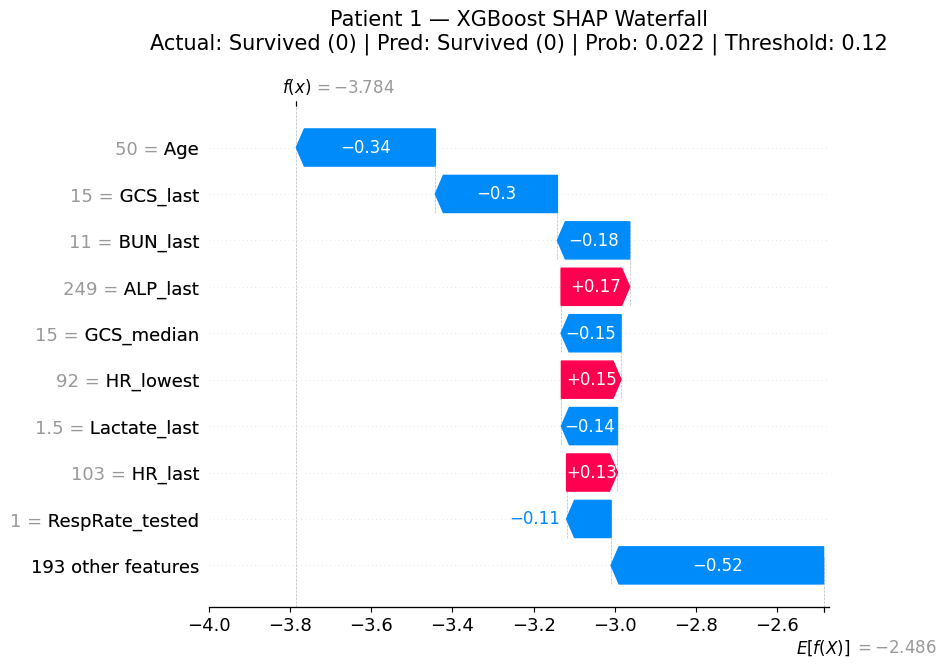

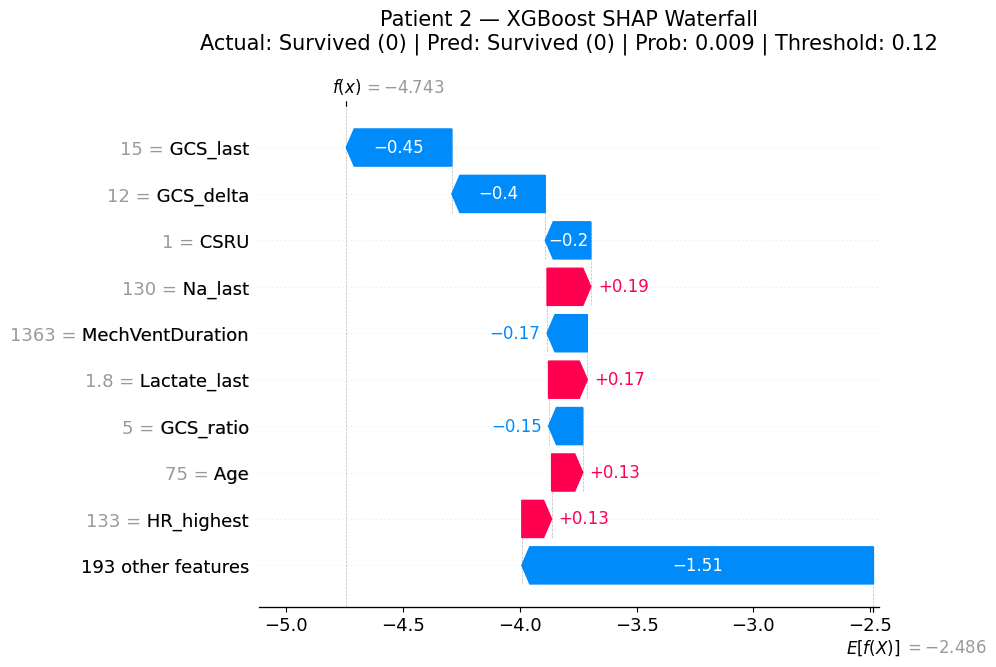

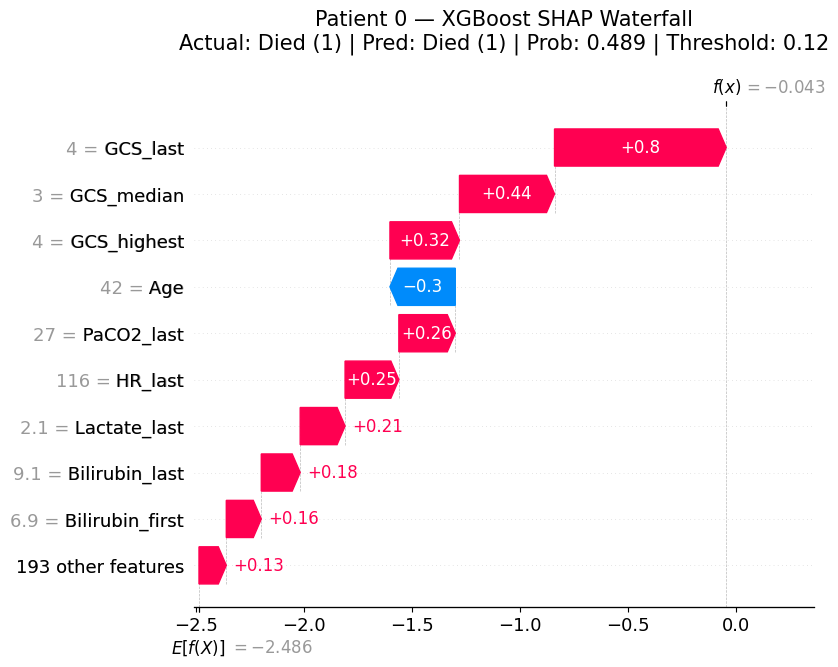

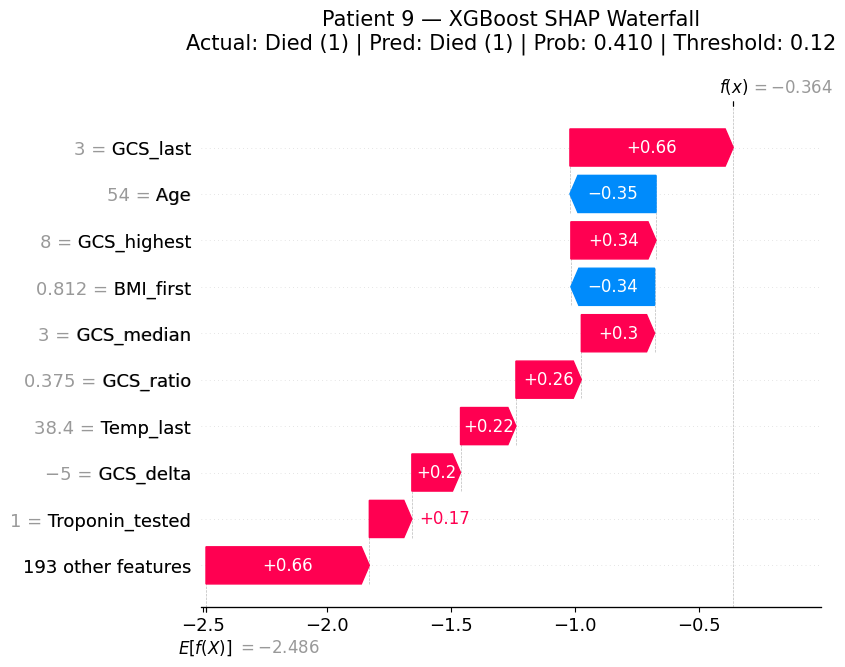

In [107]:
# Selected patients for SHAP Waterfall plots for detailed explanation
selected_results=false_negative_results[:3]+false_positive_results[:3]+true_negative_results[:2]+true_positive_results[:2]

for index_id in selected_results:

    # Determine actual outcome label text
    actual_value = int(test_results.iloc[index_id]['y_true'])
    actual_label = "Died" if actual_value == 1 else "Survived"
    
    # Determine predicted label text
    pred_value = int(test_results.iloc[index_id]['y_pred'])
    pred_label = "Died" if pred_value == 1 else "Survived"

    shap.plots.waterfall(shap_values_test[index_id],show=False)
    plt.title(
        f"Patient {index_id} — XGBoost SHAP Waterfall\n"
        f"Actual: {actual_label} ({actual_value}) | "
        f"Pred: {pred_label} ({pred_value}) | "
        f"Prob: {test_results.iloc[index_id]['y_prob']:.3f} | "
        f"Threshold: {xgb_threshold}",
        fontsize=15,
        pad=20
    )
    plt.savefig(r'./results/Xgb_Engineered_Features_SHAP_waterfall_patient_'+str(index_id)+'.png', dpi=150, bbox_inches='tight')
    plt.show()


### Decision Tree Plots

<Figure size 2400x1800 with 0 Axes>

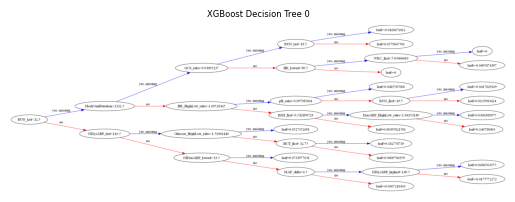

<Figure size 2400x1800 with 0 Axes>

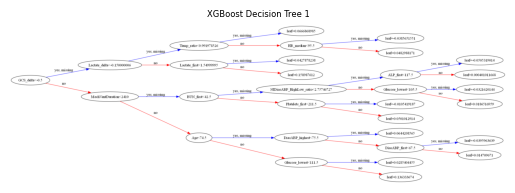

<Figure size 2400x1800 with 0 Axes>

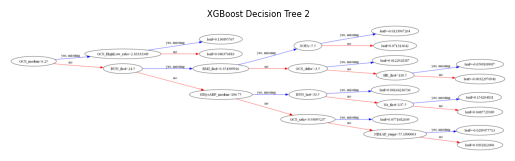

<Figure size 2400x1800 with 0 Axes>

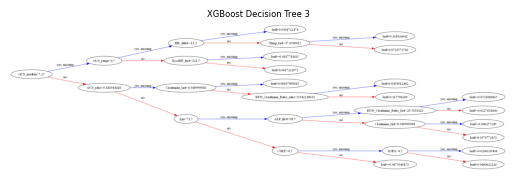

<Figure size 2400x1800 with 0 Axes>

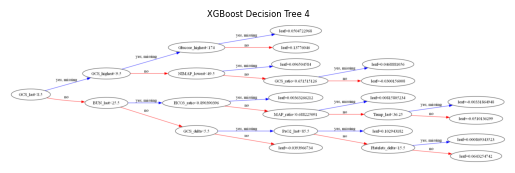

In [108]:
# Visualize the first 5 trees from the XGBoost model
for i in range(5):
    plt.figure(figsize=(24, 18))
    xgb.plot_tree(xgb_best_model, num_trees=i, rankdir='LR')
    plt.title(f"XGBoost Decision Tree {i}", fontsize=6)
    plt.savefig(r'./results/xgb_tree_'+str(i)+'.png', dpi=150, bbox_inches='tight')
    plt.show()

## Calibration Curves

In [109]:
# Logistic Regression (baseline)
prob_true_baseline, prob_pred_baseline = calibration_curve(y_test, y_prob_test, n_bins=15)

# Logistic Regression
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_prob_test_logreg_fe, n_bins=15)

# XGBoost
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_xgb_probs, n_bins=15)

In [110]:
# Brier score calculation
brier_baseline= brier_score_loss(y_test, y_prob_test)
brier_lr = brier_score_loss(y_test, y_prob_test_logreg_fe)
brier_xgb = brier_score_loss(y_test, y_xgb_probs)

print(f"Brier Score - Baseline: {brier_baseline:.4f}")
print(f"Brier Score - LR: {brier_lr:.4f}")
print(f"Brier Score - XGB: {brier_xgb:.4f}")

Brier Score - Baseline: 0.1481
Brier Score - LR: 0.0878
Brier Score - XGB: 0.0877


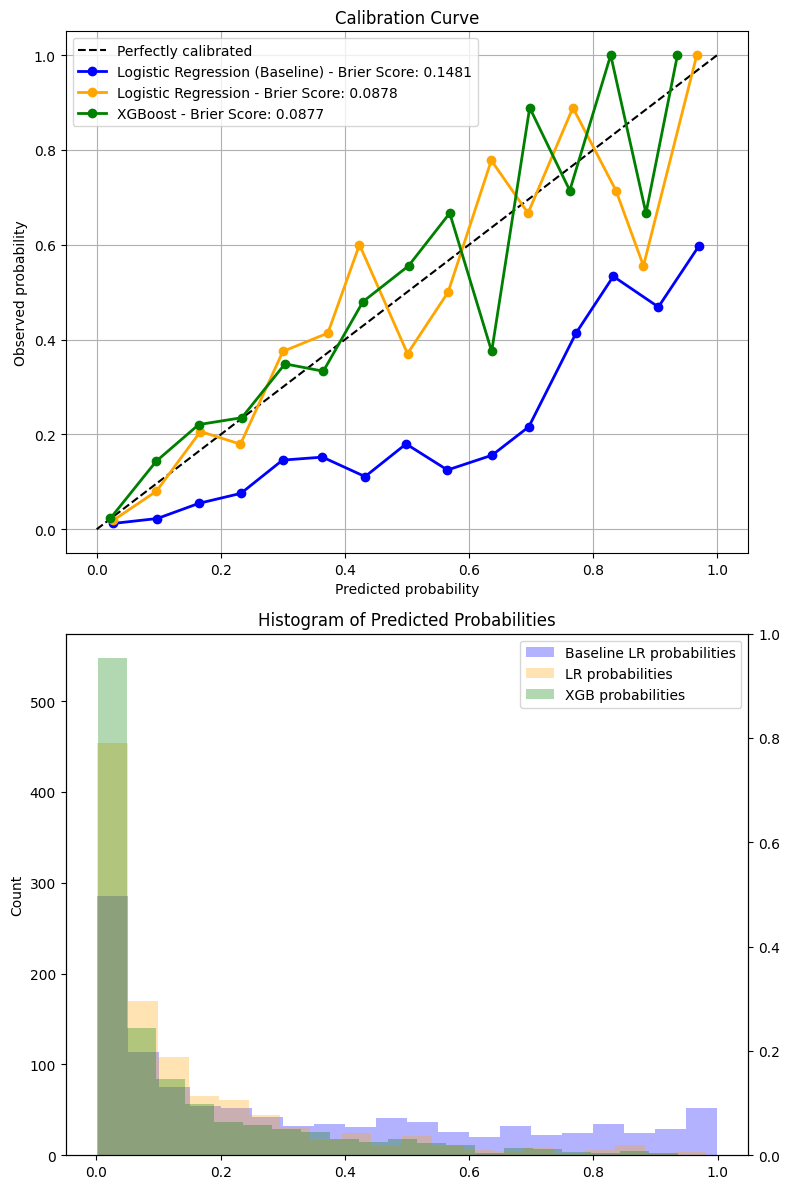

In [111]:
# Visualization of Calibration Curves and Histograms of Predicted Probabilities of all Models

# Create a single figure with 4 subplots
fig, axes = plt.subplots(2, 1, figsize=(8,12))

# Perfectly calibrated line
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
# Logistic Regression (baseline)
axes[0].plot(prob_pred_baseline, prob_true_baseline, marker='o', color='blue',label=f'Logistic Regression (Baseline) - Brier Score: {brier_baseline:.4f}', linewidth=2)
# Logistic Regression
axes[0].plot(prob_pred_lr, prob_true_lr, marker='o', color='orange', label=f'Logistic Regression - Brier Score: {brier_lr:.4f}', linewidth=2)
# XGBoost
axes[0].plot(prob_pred_xgb, prob_true_xgb, marker='o', color='green', label=f'XGBoost - Brier Score: {brier_xgb:.4f}', linewidth=2)
axes[0].set_xlabel('Predicted probability')
axes[0].set_ylabel('Observed probability')
axes[0].set_title('Calibration Curve')
axes[0].legend()
axes[0].grid(True)


# Add histograms of predicted probabilities on the same figure
axes[1].twinx()
axes[1].hist(y_prob_test, bins=20, alpha=0.3, color='blue', label='Baseline LR probabilities', density=False)
axes[1].hist(y_prob_test_logreg_fe, bins=20, alpha=0.3, color='orange', label='LR probabilities', density=False)
axes[1].hist(y_xgb_probs, bins=20, alpha=0.3, color='green', label='XGB probabilities')
axes[1].set_ylabel('Count')
axes[1].legend(loc='upper right')
axes[1].set_title('Histogram of Predicted Probabilities')

plt.tight_layout()
plt.savefig(r'./results/Calibration_Curve_and_Probability_Histogram.png', dpi=150, bbox_inches='tight')
plt.show()

## Feature-Engineered Models Summary

The inclusion of engineered temporal features led to consistent performance improvements across both models compared to the baseline, indicating that capturing patient-relative changes over time provides meaningful predictive information beyond static clinical measurements.

**Performance Metrics**
| Model                          | Features         | Threshold | Recall          | Precision      | FPR            | Accuracy        | PR AUC | ROC-AUC | Brier Score |
|:-------------------------------|:-----------------|:----------|:----------------|:---------------|:---------------|:----------------|:-------|:--------|:------------|
| Logistic Regression (baseline) | Raw              | 0.50      | 0.75 (113/150)  | 0.38 (113/299) | 0.20 (186/911) | 0.79 (838/1061) | 0.52   | 0.85    | 0.15        |
| Logistic Regression            | Raw + Engineered | 0.14      | 0.83 (124/150)  | 0.36 (124/346) | 0.22 (222/911) | 0.77 (813/1061) | 0.54   | 0.87    | 0.088       |
| XGBoost                        | Raw + Engineered | 0.12      | 0.83 (124/150)  | 0.38 (124/323) | 0.24 (199/911) | 0.79 (836/1061) | 0.54   | 0.87    | 0.088       |

- Thresholds were selected to prioritize recall in order to minimize the risk of missing critically ill patients, while maintaining a manageable false positive rate to limit unnecessary strain on clinical resources.
- At the selected thresholds with engineered features, both models correctly identified 83% of patients who died (26/150 missed), while keeping the false positive rate below 25%, reflecting a balanced trade-off between sensitivity and specificity.
- XGBoost achieved slightly higher precision and accuracy than Logistic Regression while maintaining equivalent recall.
- Both models achieved a Brier Score of 0.088, indicating improved alignment between predicted probabilities and observed outcomes relative to the baseline.
- Both models demonstrate improved calibration relative to the baseline model, with predicted probabilities generally aligning with observed ICU outcomes. However, the calibration curve becomes increasingly volatile at higher predicted probability ranges, which is most likely attributable to limited sample sizes in the positive (non-survived) class and may also reflect uncertainty in model fitting at extreme probability ranges.

# Key Insights

## EDA Insights
- The ICU target outcome is highly imbalanced, indicating that model evaluation should emphasize precision–recall based metrics rather than accuracy.
- Many physiological features are non-normally distributed, with extreme outliers and substantial overlap between survived and non-survived patients, suggesting that no single feature alone has sufficient discriminative power to predict ICU outcome.
- Missing data is present at both the patient level and feature level, highlighting that missing data itself may be informative in ICU settings, while also requiring that patients have sufficient clinical data to support reliable modeling and predictions.
- **Statistical Analysis Insights**:
    - Univariate statistical tests show that many features are not significantly different between survived and non-survived patients.
    - However, univariate statistical significance does not consistently align with model-derived feature importance, indicating that ICU outcomes are driven by multivariate and non-linear feature interactions that are not captured by marginal statistical tests.

## Feature Insights
- Both Logistic Regression and XGBoost leverage a combination of raw clinical measurements and engineered temporal features, highlighting the predictive value of capturing patient-level changes over time.
- Key raw features such as `GCS_last`, `Age`, and `BUN_last` consistently appear among the top contributors across all models.
- Engineered temporal features, including `GCS_delta`, `GCS_ratio`, and `BUN_Creatinine_Ratio_last`, also rank highly, demonstrating the importance of modeling trends and relative changes rather than absolute values alone.
- These patterns suggest that recent neurological status and renal function are strong predictors of ICU outcomes, with age further influencing risk.
- **Interpretability Examples**
    - `GCS_last` reflects the patient’s most recent neurological status, while `GCS_delta` and `GCS_ratio` quantify improvement or deterioration since ICU admission. Higher values correspond to neurological recovery and are associated with lower predicted risk, as shown in XGBoost SHAP plots.
    - `BUN_last` represents current renal function, and `BUN_Creatinine_Ratio_last` captures potential renal dysfunction or dehydration. Higher values are associated with increased predicted risk.
    - `Age` is a static feature, with older patients consistently exhibiting higher predicted risk, in line with SHAP-based interpretations.

## Model Evaluation Insights
- Both Logistic Regression and XGBoost demonstrate improved performance with the inclusion of engineered temporal features, which capture patient trajectory information beyond static clinical measurements used in the baseline model.
- XGBoost effectively captures complex, non-linear interactions among features without requiring explicit feature exclusion.
- Logistic Regression assigns zero coefficients to 135 of 202 features, many of which are highly correlated with retained variables, reflecting reliance on a compact, linearly independent subset of discriminative features.
- This contrast highlights the multivariate and non-linear nature of ICU outcomes, where tree-based models complement linear approaches.
- Operating thresholds were selected to balance the clinical trade-off between false negatives (missed non-survived patients) and false positives (unnecessary strain on hospital resources).
- Despite performance gains from feature engineering features, the limited number of positive cases constrains further improvements.
- The dataset contains extreme values and noise, likely reflecting rare but clinically meaningful events that pose challenges for model learning.
- Across all models, `GCS`, `BUN`, and `Age` consistently emerge as influential features, reinforcing that accurate ICU outcome prediction requires integrating multiple interacting variables rather than relying on any single measurement.
- Several variables show non-significant associations in univariate statistical tests but contribute meaningfully in multivariate models, particularly through engineered temporal transformations (e.g., `GCS_delta` derived from first and last measurements), highlighting that univariate tests alone do not capture the full complexity of feature–outcome relationships.


## Limitations and Future Work
- **Limitations**: The dataset is relatively small, originates from a single source (Kaggle), and lacks detailed temporal information such as exact measurement timestamps and treatment data. These limitations restrict the ability to model rates of deterioration or recovery and to account for clinical interventions in a temporally accurate way. These constraints are likely due to patient privacy considerations.
- **Future Work**: Apply the models to larger, multi-institutional ICU datasets with richer temporal and treatment information. Evaluate generalization performance and assess whether learned temporal patterns remain consistent across diverse patient populations, while ensuring the clinical data was collected well before the patient outcome.
